# Train the StarNet Model

This notebook takes you through the steps of how to train a StarNet Model
- Required Python packages: `numpy h5py keras`
- Required data files: training_data.h5, mean_and_std.npy

Note: We use tensorflow for the keras backend.

In [1]:
from tensorflow.keras import backend as K

In [2]:
K.clear_session()

In [3]:
import numpy as np
import h5py
import random
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, InputLayer, Flatten, Reshape, Concatenate, concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import HDF5Matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import os
from sklearn.model_selection import train_test_split

2.3.1


In [4]:
from tensorflow.keras.layers import LeakyReLU

In [5]:
sorted(os.listdir())

['.DS_Store',
 '.ipynb_checkpoints',
 'CNN_MIST_normrvs_bprp_feh_logteff_logg_age_v0_hyperas.ipynb',
 '__pycache__']

In [6]:
def data():
    #Loading the data
    #RVSFlux
    pathrvs = '/Users/aishasultan/work/synple-gaia/run/CNN/age_parameter/RVS/spectra/normspectra_feh_pos00+pos.25+neg.25.npy'
    norm_rvsflux = np.load (pathrvs)
    print('shape of norm rvsflux:', np.shape(norm_rvsflux))
    
    #BPFlux
    pathbp = '/Users/aishasultan/work/synple-gaia/run/CNN/age_parameter/BP/spectra/spectra_feh_pos00+pos.25+neg.25.h5'
    readbp = h5py.File(pathbp, 'r') 
    bpflux = readbp.get('bpflux')
    bpflux = np.array(bpflux)
    print('shape of bpflux:', np.shape(bpflux))


    norm_bpflux= []

    for ii in range(np.shape(bpflux)[0]):    
        max_flux= np.max(bpflux[ii])
        normflux = bpflux[ii]/ max_flux
        #plt.plot(np.arange(33), normflux)
        #print('normflux:',normflux)
        norm_bpflux.append(normflux)



    norm_bpflux= np.array(norm_bpflux)

    #print('shape of norm bpflux:', np.shape(norm_bpflux))
    #print('shape of norm bpflux:', print(norm_bpflux[0:10]))
    
    #RPFlux
    pathrp ='/Users/aishasultan/work/synple-gaia/run/CNN/age_parameter/RP/spectra/spectra_feh_pos00+pos.25+neg.25.h5'
    readrp = h5py.File(pathrp, 'r')
    print(readrp.keys())
    rpflux = readrp.get('rpflux')
    rpflux = np.array(rpflux)
    print('shape of rpflux:', np.shape(rpflux))


    norm_rpflux= []
    for ii in range(np.shape(rpflux)[0]):
            max_flux= np.max(rpflux[ii])
            normflux = rpflux[ii]/ max_flux
            #plt.plot(np.arange(40), normflux)
            #print('normflux:',normflux)
            norm_rpflux.append(normflux)


    norm_rpflux= np.array(norm_rpflux)

    #print('shape of norm_rpflux:', np.shape(norm_rpflux))
    #print('output of norm_flux:', print(norm_rpflux[0:10]))

    mist0 = '/Users/aishasultan/work/MIST/feh_pos0.00_100randstr_EEP0.h5'
    mist1 = '/Users/aishasultan/work/MIST/feh_pos.25_100randstr_EEP0.h5'
    mist2 = '/Users/aishasultan/work/MIST/feh_neg.25_100randstr_EEP0.h5'


    readmist0 = h5py.File(mist0, 'r')
    readmist1 = h5py.File(mist1, 'r')
    readmist2 = h5py.File(mist2, 'r')


    #reading MIST0 file
    print(readmist0.keys())
    mist_logteff0 = readmist0.get('logteff_sel')
    teff_sel0 = np.array(mist_logteff0)
    mist_logg0 = readmist0.get ('logg_sel')
    logg_sel0 = np.array(mist_logg0)
    mist_feh0 = readmist0.get ('feh_sel')
    feh_sel0 = np.array(mist_feh0)
    mist_age0 = readmist0.get ('age_sel')
    age_sel0 = np.array(mist_age0)


    #reading MIST1 file
    #print(readmist1.keys())
    mist_logteff1 = readmist1.get('logteff_sel')
    teff_sel1 = np.array(mist_logteff1)
    mist_logg1 = readmist1.get ('logg_sel')
    logg_sel1 = np.array(mist_logg1)
    mist_feh1 = readmist1.get ('feh_sel')
    feh_sel1 = np.array(mist_feh1)
    mist_age1 = readmist1.get ('age_sel')
    age_sel1 = np.array(mist_age1)

    #reading MIST2 file
    #print(readmist1.keys())
    mist_logteff2 = readmist2.get('logteff_sel')
    teff_sel2 = np.array(mist_logteff2)
    mist_logg2 = readmist2.get ('logg_sel')
    logg_sel2 = np.array(mist_logg2)
    mist_feh2 = readmist2.get ('feh_sel')
    feh_sel2 = np.array(mist_feh2)
    mist_age2 = readmist2.get ('age_sel')
    age_sel2 = np.array(mist_age2)


    #MIST all parameters
    logteff = np.hstack((teff_sel0, teff_sel1, teff_sel2))
    logg = np.hstack ((logg_sel0, logg_sel1, logg_sel2))
    feh = np.hstack ((feh_sel0, feh_sel1, feh_sel2))
    age = np.hstack ((age_sel0, age_sel1, age_sel2))
    
    all_input_data = np.stack([logteff, logg, feh, age], axis=1)

    print(age.max())
    print(feh)
    
    #features
    num_tot = len(logteff)
    print('total number of input stars =', num_tot)
    np.random.seed(0)
    plim = 0.8
    ran_frac = np.random.uniform(0,1,num_tot)
    #print('ranfrac=' , ran_frac)

    #Input flux data of RVS, BP, RP
    x_RVStrain = norm_rvsflux[ran_frac < plim, :]
    print('number of RVS training data=', len(x_RVStrain[:,0]))
    x_RVScv = norm_rvsflux[ran_frac >= plim, :] #test set we left for the application

    x_BPtrain = norm_bpflux[ran_frac < plim, :]
    print('number of BP training data=', len(x_BPtrain[:,0]))
    x_BPcv = norm_bpflux[ran_frac >= plim, :]

    x_RPtrain =norm_rpflux[ran_frac < plim, :]
    print('number of RP training data=', len(x_RPtrain[:,0]))
    x_RPcv = norm_rpflux[ran_frac >= plim, :]

    #print('x_BPtrain', x_BPtrain)

    #x_train_combined = np.vstack (x_RVStrain[0,:], x_RPtrain[0,:]) 

    #output label which is the logteff, log g, feh, and age
    y_logteff_train = logteff[ran_frac< plim]
    y_logteff_cv = logteff[ran_frac >= plim] #test set

    y_logg_train = logg[ran_frac< plim]
    y_logg_cv = logg[ran_frac >= plim] #test set

    y_feh_train = feh[ran_frac< plim]
    y_feh_cv = feh[ran_frac >= plim] #test set

    y_age_train = age[ran_frac< plim]
    y_age_cv = age[ran_frac >= plim] #test set

    print('The size of CVS for the input flux data')
    #print('RVS cvs=', np.shape(x_RVScv))
    #print('BP cvs=', np.shape(x_BPcv))
    print('RP cvs=', np.shape(x_RPcv))

    print('the size of output label=', np.shape(y_logteff_train) )

    #id = np.linspace(0, len(x_RVStrain[:, 0])-1, len(x_RVStrain[:, 0]))
    #plt.plot(id, y_logteff_train)
    #plt.show()
    
    #mean_labels=np.mean(logteff)
    #std_labels=np.std(logteff)
    #print('mean and std teff=', mean_labels, std_labels)
    # def normalize(labels):
    #     # Normalize labels
    #     mean_labels=np.mean(labels)
    #     std_labels=np.std(labels)
    #     return (labels-mean_labels) / std_labels, mean_labels, std_labels


    # def normalize_test(labels, mean, std):
    #     return (labels - mean) / std

    def normalize(labels):
        # Normalize labels
        min_labels=np.min(labels)
        max_labels=np.max(labels)
        return (labels-min_labels) / (max_labels - min_labels), min_labels, max_labels


    def normalize_test(labels, min_value, max_value):
        return (labels - min_value) / (max_value - min_value)
    
    #normalize the y labels, the log teff and log g 

    #output label which is the logteff and log g
    # y_logteff_train, mean_ylt_train, std_ylt_train = normalize(y_logteff_train)
    # y_logteff_cv = normalize_test(y_logteff_cv, mean_ylt_train, std_ylt_train)

    # y_logg_train, mean_yl_train, std_lt_train = normalize(y_logg_train)
    # y_logg_cv = normalize_test(y_logg_cv, mean_yl_train, std_lt_train)

    # y_feh_train, mean_yf_train, std_yf_train = normalize(y_feh_train)
    # y_feh_cv = normalize_test(y_feh_cv, mean_yf_train, std_yf_train) #test set

    # y_age_train, mean_ya_train, std_ya_train = normalize(y_age_train)
    # y_age_cv = normalize_test(y_age_cv, mean_ya_train, std_ya_train) #test set



    y_logteff_train, min_ylt_train, max_ylt_train = normalize(y_logteff_train)
    y_logteff_cv = normalize_test(y_logteff_cv, min_ylt_train, max_ylt_train)

    y_logg_train, min_yl_train, max_lt_train = normalize(y_logg_train)
    y_logg_cv = normalize_test(y_logg_cv, min_yl_train, max_lt_train)

    y_feh_train, min_yf_train, max_yf_train = normalize(y_feh_train)
    y_feh_cv = normalize_test(y_feh_cv, min_yf_train, max_yf_train) #test set

    y_age_train, min_ya_train, max_ya_train = normalize(y_age_train)
    y_age_cv = normalize_test(y_age_cv, min_ya_train, max_ya_train) #test set
    
    print('type of data ', type(y_logteff_train),type(y_logteff_cv),
          type(y_logg_train),type(y_logg_cv), 
         type(y_feh_train),type(y_feh_cv), 
         type(y_age_train), type(y_age_cv))
    
    x_train = [x_RVStrain, x_BPtrain, x_RPtrain]
    y_train = np.stack([y_logteff_train, y_logg_train, y_feh_train, y_age_train], axis=1)
    x_test = [x_RVScv, x_BPcv, x_RPcv]
    y_test = np.stack([y_logteff_cv, y_logg_cv, y_feh_cv, y_age_cv], axis=1)

    return x_train, y_train, x_test, y_test

**Build the StarNet model architecture**

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

First, let's define some model variables.

**More model techniques**
* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function
* `EarlyStopping` uses the cross-validation set to test the model following every iteration and stops the training if the cv loss does not decrease by `min_delta` after `patience` iterations
* `ReduceLROnPlateau` is a form of learning rate decay where the learning rate is decreased by a factor of `factor` if the training loss does not decrease by `epsilon` after `patience` iterations unless the learning rate has reached `min_lr`

In [7]:
from hyperas import optim
from hyperopt import tpe, Trials
from hyperas.distributions import choice

Using TensorFlow backend.


In [8]:
def create_model(x_train, y_train, x_test, y_test):
    # activation function used following every layer except for the output layers
    activation = ['relu', 'sigmoid', 'tanh']
    #activation = 'sigmoid'

    # model weight initializer
    initializer = 'he_normal'

    # number of filters used in the convolutional layers
    #num_filters = [4,16]
    num_filters = [8,32]
#     num_filters = [32,32*2]
    #num_filters = [8,16]

    # length of the filters in the convolutional layers
    #filter_length = 8
    #filter_length = 16
    filter_length = 8

    # length of the maxpooling window 
    pool_length = 4

    # number of nodes in each of the hidden fully connected layers
    num_hidden = [256,128]
    #num_hidden = [24,12]

    # number of spectra fed into model at once during training
    batch_size = 64

    # maximum number of interations for model training
    #max_epochs = 180
    #max_epochs = 450
    #max_epochs = 300
    max_epochs = 1000


    # initial learning rate for optimization algorithm
    lr = 0.000003 #handled by Adam

    # exponential decay rate for the 1st moment estimates for optimization algorithm
    beta_1 = 0.9

    # exponential decay rate for the 2nd moment estimates for optimization algorithm
    beta_2 = 0.999

    # a small constant for numerical stability for optimization algorithm
    optimizer_epsilon = 1e-08
    
    x_RVStrain, x_BPftrain, x_RPftrain = x_train
    
    num_RVSfluxes=len(x_RVStrain[0,:]) 
    print('number of RVS fluxes=', num_RVSfluxes)

    num_BPfluxes=len(x_BPtrain[0,:]) 
    print('number of BP fluxes=', num_BPfluxes)

    num_RPfluxes=len(x_RPtrain[0,:]) 
    print('number of RP fluxes=', num_RPfluxes)

    num_labels= 4
    print('number of training labels=', num_labels)

    #ilam = np.linspace(0, num_fluxes-1, num_fluxes)
    #plt.plot(ilam, x_train[329, :])
    #plt.plot()

    #iy = np.linspace(0, len(y_train)-1, len(y_train))
    #plt.plot(iy, y_train)
    #plt.plot()
    
    
    # Input RVS spectra
    print(' num_RVSfluxes=', num_RVSfluxes)
    input_RVSspec = Input(shape=(num_RVSfluxes,), name='rvs_input_x' ) #removed name='starnet_input_x'

    # Reshape spectra for RVS layers
    cur_rvs = Reshape((num_RVSfluxes, 1))(input_RVSspec)

    # CNN layers
    activation_function = {{choice(['tanh', 'relu', 'sigmoid'])}}
    print(0, activation_function)
    cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation_function,
                    padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rvs) #first CNN layer
    activation_function = {{choice(['sigmoid', 'relu'])}}
    print(1, activation_function)
    cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation_function,
                    padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rvs) #2nd CNN layer

    # Max pooling layer
    cur_rvs = MaxPooling1D(pool_size=pool_length)(cur_rvs)

    # Flatten the current input for the fully-connected layers
    cur_rvs = Flatten()(cur_rvs)


    ##############################################################################################


    # Input BP spectra
    print(' num_BPfluxes=', num_BPfluxes)
    input_BPspec = Input(shape=(num_BPfluxes,), name='bp_input_x' ) #removed name='starnet_input_x'

    # Reshape spectra for BP layers
    cur_bp = Reshape((num_BPfluxes, 1))(input_BPspec)

    # CNN layers
    activation_function = {{choice(['tanh', 'relu', 'sigmoid'])}}
    print(3, activation_function)
    cur_bp = Conv1D(kernel_initializer=initializer, activation=activation_function, 
                    padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_bp) #first CNN layer
    activation_function = {{choice(['sigmoid', 'relu'])}}
    print(4, activation_function)
    cur_bp = Conv1D(kernel_initializer=initializer, activation=activation_function,
                    padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_bp) #2nd CNN layer

    # Max pooling layer
    cur_bp = MaxPooling1D(pool_size=pool_length)(cur_bp)


    # Flatten the current input for the fully-connected layers
    cur_bp = Flatten()(cur_bp)


    ################################################################################################

    # Input RP spectra
    input_RPspec = Input(shape=(num_RPfluxes,), name='rp_input_x' ) #removed name='starnet_input_x'

    # Reshape spectra for CNN layers
    cur_rp = Reshape((num_RPfluxes, 1))(input_RPspec)

    # CNN layers
    activation_function = {{choice(['tanh', 'relu', 'sigmoid'])}}
    print(5, activation_function)
    cur_rp = Conv1D(kernel_initializer=initializer, activation=activation_function, 
                    padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rp) #first CNN layer
    activation_function = {{choice(['sigmoid', 'relu'])}}
    print(6, activation_function)
    cur_rp = Conv1D(kernel_initializer=initializer, activation=activation_function,
                    padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rp) #2nd CNN layer

    # Max pooling layer
    cur_rp = MaxPooling1D(pool_size=pool_length)(cur_rp)

    # Flatten the current input for the fully-connected layers
    cur_rp = Flatten()(cur_rp)

    ###############################################################################################

    #concatenate RVS/BP/RP and then insert it to dense layer 

    cur_comb = Concatenate()([cur_rvs, cur_bp, cur_rp])

    #cur_comb = cur_comb

    # Fully-connected layers
    activation_function = {{choice(['tanh', 'relu', 'sigmoid'])}}
    print(7, activation_function)
    cur_final = Dense(units=num_hidden[0], kernel_initializer=initializer, 
                   activation=activation_function)(cur_comb)
    activation_function = {{choice(['sigmoid', 'relu'])}}
    print(8, activation_function)
    cur_final = Dense(units=num_hidden[1], kernel_initializer=initializer, 
                   activation=activation_function)(cur_final)

    # Output nodes
    if {{choice(['linear', 'leaky_relu'])}} == 'linear':
        output_final = Dense(units=num_labels, activation='linear', 
                            input_dim=num_hidden[1], name='output_y')(cur_final)
    else:
        output_final = Dense(units=num_labels,
                    input_dim=num_hidden[1], name='output_y')(cur_final)
        output_final = LeakyReLU()(output_final)



    model = Model(inputs = [input_RVSspec, input_BPspec, input_RPspec], outputs=output_final)

    #model = Model(inputs = [input_RPspec], outputs=output_final)
    
    # Default loss function parameters
    early_stopping_min_delta = 0.0007
    early_stopping_patience = 4
    reduce_lr_factor = 0.5
    reuce_lr_epsilon = 0.0000009
    reduce_lr_patience = 2
    reduce_lr_min = 0.00008

    # loss function to minimize
    loss_function = 'mean_squared_error'

    # compute mean absolute deviation
    metrics = ['mae', 'mse']
    #metrics = ['mae']
    
    #optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)
    optimizer = Adam(lr=0.0001)

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                           patience=early_stopping_patience, verbose=2, mode='min')

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                      patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)
    
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    model.summary()
    
    
    #history = model.fit(x_train, y_train, validation_data=(x_cv, y_cv),
              #epochs=max_epochs, verbose=1, shuffle='batch',
             #callbacks=[early_stopping, reduce_lr])
        

#     y_train_stack = np.column_stack((y_logteff_train, y_logg_train, y_feh_train, y_age_train))
#     y_cv_stack = np.column_stack ((y_logteff_cv, y_logg_cv, y_feh_cv, y_age_cv))

#     print('shape of the cv logteff and logg=', np.shape(y_cv_stack))
#     print(' shape of y teff and logg=', np.shape(y_train_stack))

    print('shape of the cv logteff and logg=', np.shape(y_test))
    print(' shape of y teff and logg=', np.shape(y_train))

    #history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y=y_train_stack,
              #validation_split=0.2, epochs=max_epochs, verbose=1, shuffle='batch')

    #history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y= y_train_stack, 
                        #validation_data=([x_RVScv, x_BPcv, x_RPcv], y_cv_stack),
              #epochs=max_epochs, verbose=1, shuffle='batch')

    history = model.fit(x=x_train, y= y_train, 
                        validation_data=(x_test, y_test),
              epochs=40, verbose=2, shuffle='batch')
    validation_loss = np.min(history.history['val_mae'])
    print('Best validation loss of epoch:', validation_loss)
    return {'loss': validation_loss, 'status': STATUS_OK, 'model': model}

In [9]:
X_train, Y_train, X_test, Y_test = data()

shape of norm rvsflux: (300, 1134)
shape of bpflux: (300, 33)
<KeysViewHDF5 ['rpflux']>
shape of rpflux: (300, 40)
<KeysViewHDF5 ['age_sel', 'feh_sel', 'logg_sel', 'logteff_sel']>
10.3
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.

In [10]:
Y_train.min(), Y_train.max()

(0.0, 1.0)

In [11]:
Y_test.min(), Y_test.max()

(-0.1022727272727273, 1.0218519268253974)

In [12]:
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='CNN_MIST_normrvs_bprp_feh_logteff_logg_age_v0_hyperas')

>>> Imports:
#coding=utf-8

try:
    from tensorflow.keras import backend as K
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import h5py
except:
    pass

try:
    import random
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from tensorflow.keras.models import Model
except:
    pass

try:
    from tensorflow.keras.layers import Input, Dense, InputLayer, Flatten, Reshape, Concatenate, concatenate
except:
    pass

try:
    from tensorflow.keras.layers import Conv1D
except:
    pass

try:
    from tensorflow.keras.layers import MaxPooling1D
except:
    pass

try:
    from tensorflow.keras.optimizers import Adam
except:
    pass

try:
    from tensorflow.keras.optimizers import RMSprop
except:
    pass

try:
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
except:
    pass

try:
    from tensorflow.keras.utils import HDF5Matrix
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    impo

number of RVS fluxes=                                
1134                                                 
number of BP fluxes=                                 
33                                                   
number of RP fluxes=                                 
40                                                   
number of training labels=                           
4                                                    
 num_RVSfluxes=                                      
1134                                                 
0                                                    
sigmoid                                              
1                                                    
sigmoid                                              
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/anaconda3/lib/python3.6/site-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "    " (length: 4) as well as "        " (length: 8)
  indent, len(indent), new_indent, len(new_indent)))
/anaconda3/lib/python3.6/site-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "        " (length: 8) as well as "    " (length: 4)
  indent, len(indent), new_indent, len(new_indent)))


 num_BPfluxes=                                       
33                                                   
3                                                    
relu                                                 
4                                                    
relu                                                 
5                                                    
relu                                                 
6                                                    
sigmoid                                              
7                                                    
tanh                                                 
8                                                    
relu                                                 
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:`epsilon` argument is deprecated and will be removed, use `min_delta` instead.
Model: "functional_1"                                
_______________________________________

8/8 - 0s - loss: 0.8985 - mae: 0.6812 - mse: 0.8985 - val_loss: 0.1961 - val_mae: 0.3217 - val_mse: 0.1961

Epoch 2/40                                           
8/8 - 0s - loss: 0.2202 - mae: 0.3472 - mse: 0.2202 - val_loss: 0.1448 - val_mae: 0.3151 - val_mse: 0.1448

Epoch 3/40                                           
8/8 - 0s - loss: 0.1267 - mae: 0.2922 - mse: 0.1267 - val_loss: 0.1254 - val_mae: 0.2788 - val_mse: 0.1254

Epoch 4/40                                           
8/8 - 0s - loss: 0.1076 - mae: 0.2698 - mse: 0.1076 - val_loss: 0.1244 - val_mae: 0.2964 - val_mse: 0.1244

Epoch 5/40                                           
8/8 - 0s - loss: 0.1246 - mae: 0.2790 - mse: 0.1246 - val_loss: 0.1043 - val_mae: 0.2623 - val_mse: 0.1043

Epoch 6/40                                           
8/8 - 0s - loss: 0.0918 - mae: 0.2511 - mse: 0.0918 - val_loss: 0.1093 - val_mae: 0.2691 - val_mse: 0.1093

Epoch 7/40                                           
8/8 - 0s - loss: 0.1208 - ma

8/8 - 1s - loss: 0.2113 - mae: 0.3828 - mse: 0.2113 - val_loss: 0.1490 - val_mae: 0.3134 - val_mse: 0.1490

Epoch 2/40                                                                     
8/8 - 0s - loss: 0.1193 - mae: 0.2818 - mse: 0.1193 - val_loss: 0.1172 - val_mae: 0.2799 - val_mse: 0.1172

Epoch 3/40                                                                     
8/8 - 0s - loss: 0.1046 - mae: 0.2530 - mse: 0.1046 - val_loss: 0.1041 - val_mae: 0.2656 - val_mse: 0.1041

Epoch 4/40                                                                     
8/8 - 0s - loss: 0.0977 - mae: 0.2542 - mse: 0.0977 - val_loss: 0.1015 - val_mae: 0.2625 - val_mse: 0.1015

Epoch 5/40                                                                     
8/8 - 0s - loss: 0.0920 - mae: 0.2478 - mse: 0.0920 - val_loss: 0.1020 - val_mae: 0.2720 - val_mse: 0.1020

Epoch 6/40                                                                     
8/8 - 0s - loss: 0.0938 - mae: 0.2537 - mse: 0.0938 - val_lo

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 40%|████      | 2/5 [00:27<00:41, 13.68s/trial, best loss: 0.2552943527698517]WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1504a3378> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the 

Epoch 37/40                                                                    
8/8 - 0s - loss: 0.0855 - mae: 0.2379 - mse: 0.0855 - val_loss: 0.0992 - val_mae: 0.2611 - val_mse: 0.0992

Epoch 38/40                                                                    
8/8 - 0s - loss: 0.0861 - mae: 0.2384 - mse: 0.0861 - val_loss: 0.0991 - val_mae: 0.2610 - val_mse: 0.0991

Epoch 39/40                                                                    
8/8 - 0s - loss: 0.0867 - mae: 0.2390 - mse: 0.0867 - val_loss: 0.0992 - val_mae: 0.2612 - val_mse: 0.0992

Epoch 40/40                                                                    
8/8 - 0s - loss: 0.0861 - mae: 0.2390 - mse: 0.0861 - val_loss: 0.0992 - val_mae: 0.2616 - val_mse: 0.0992

Best validation loss of epoch:                                                 
0.257038950920105                                                              
number of RVS fluxes=                                                          
1134    

Epoch 29/40                                                                    
8/8 - 0s - loss: 0.2247 - mae: 0.3782 - mse: 0.2247 - val_loss: 0.1409 - val_mae: 0.3107 - val_mse: 0.1409

Epoch 30/40                                                                    
8/8 - 0s - loss: 0.1300 - mae: 0.2853 - mse: 0.1300 - val_loss: 0.1342 - val_mae: 0.3112 - val_mse: 0.1342

Epoch 31/40                                                                    
8/8 - 0s - loss: 0.1185 - mae: 0.2775 - mse: 0.1185 - val_loss: 0.1260 - val_mae: 0.2852 - val_mse: 0.1260

Epoch 32/40                                                                    
8/8 - 0s - loss: 0.1604 - mae: 0.3001 - mse: 0.1604 - val_loss: 0.1693 - val_mae: 0.3106 - val_mse: 0.1693

Epoch 33/40                                                                    
8/8 - 0s - loss: 0.0971 - mae: 0.2533 - mse: 0.0971 - val_loss: 0.1813 - val_mae: 0.3204 - val_mse: 0.1813

Epoch 34/40                                                 

Epoch 21/40                                                                    
8/8 - 0s - loss: 0.0872 - mae: 0.2400 - mse: 0.0872 - val_loss: 0.0985 - val_mae: 0.2600 - val_mse: 0.0985

Epoch 22/40                                                                    
8/8 - 0s - loss: 0.0889 - mae: 0.2448 - mse: 0.0889 - val_loss: 0.0986 - val_mae: 0.2608 - val_mse: 0.0986

Epoch 23/40                                                                    
8/8 - 0s - loss: 0.0951 - mae: 0.2537 - mse: 0.0951 - val_loss: 0.1006 - val_mae: 0.2645 - val_mse: 0.1006

Epoch 24/40                                                                    
8/8 - 0s - loss: 0.0907 - mae: 0.2464 - mse: 0.0907 - val_loss: 0.1016 - val_mae: 0.2648 - val_mse: 0.1016

Epoch 25/40                                                                    
8/8 - 0s - loss: 0.0887 - mae: 0.2457 - mse: 0.0887 - val_loss: 0.0983 - val_mae: 0.2592 - val_mse: 0.0983

Epoch 26/40                                                 

In [13]:
best_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rvs_input_x (InputLayer)        [(None, 1134)]       0                                            
__________________________________________________________________________________________________
bp_input_x (InputLayer)         [(None, 33)]         0                                            
__________________________________________________________________________________________________
rp_input_x (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1134, 1)      0           rvs_input_x[0][0]                
_______________________________________________________________________________________

In [14]:
history = best_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3500)
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Epoch 1/3500
8/8 [==============================] - 0s 37ms/step - loss: 0.0868 - mae: 0.2446 - mse: 0.0868 - val_loss: 0.0984 - val_mae: 0.2617 - val_mse: 0.0984
Epoch 2/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0846 - mae: 0.2347 - mse: 0.0846 - val_loss: 0.0983 - val_mae: 0.2559 - val_mse: 0.0983
Epoch 3/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0836 - mae: 0.2352 - mse: 0.0836 - val_loss: 0.0958 - val_mae: 0.2539 - val_mse: 0.0958
Epoch 4/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0816 - mae: 0.2290 - mse: 0.0816 - val_loss: 0.0941 - val_mae: 0.2523 - val_mse: 0.0941
Epoch 5/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0789 - mae: 0.2267 - mse: 0.0789 - val_loss: 0.0911 - val_mae: 0.2475 - val_mse: 0.0911
Epoch 6/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0759 - mae: 0.2200 - mse: 0.0759 - val_loss: 0.0870 - val_mae: 0.2337 - val_mse: 0.0870
Epoch 7/3500
8/8 [====

8/8 [==============================] - 0s 33ms/step - loss: 0.0565 - mae: 0.1705 - mse: 0.0565 - val_loss: 0.0676 - val_mae: 0.1933 - val_mse: 0.0676
Epoch 52/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0545 - mae: 0.1638 - mse: 0.0545 - val_loss: 0.0664 - val_mae: 0.1861 - val_mse: 0.0664
Epoch 53/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0552 - mae: 0.1601 - mse: 0.0552 - val_loss: 0.0644 - val_mae: 0.1769 - val_mse: 0.0644
Epoch 54/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0533 - mae: 0.1596 - mse: 0.0533 - val_loss: 0.0622 - val_mae: 0.1679 - val_mse: 0.0622
Epoch 55/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0535 - mae: 0.1607 - mse: 0.0535 - val_loss: 0.0661 - val_mae: 0.1731 - val_mse: 0.0661
Epoch 56/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0545 - mae: 0.1611 - mse: 0.0545 - val_loss: 0.0637 - val_mae: 0.1707 - val_mse: 0.0637
Epoch 57/3500
8/8 [===========

8/8 [==============================] - 0s 26ms/step - loss: 0.0493 - mae: 0.1483 - mse: 0.0493 - val_loss: 0.0645 - val_mae: 0.1817 - val_mse: 0.0645
Epoch 102/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0511 - mae: 0.1557 - mse: 0.0511 - val_loss: 0.0586 - val_mae: 0.1558 - val_mse: 0.0586
Epoch 103/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0487 - mae: 0.1518 - mse: 0.0487 - val_loss: 0.0567 - val_mae: 0.1656 - val_mse: 0.0567
Epoch 104/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0476 - mae: 0.1466 - mse: 0.0476 - val_loss: 0.0589 - val_mae: 0.1656 - val_mse: 0.0589
Epoch 105/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0493 - mae: 0.1464 - mse: 0.0493 - val_loss: 0.0575 - val_mae: 0.1601 - val_mse: 0.0575
Epoch 106/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0478 - mae: 0.1448 - mse: 0.0478 - val_loss: 0.0574 - val_mae: 0.1642 - val_mse: 0.0574
Epoch 107/3500
8/8 [=====

Epoch 151/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0457 - mae: 0.1381 - mse: 0.0457 - val_loss: 0.0581 - val_mae: 0.1714 - val_mse: 0.0581
Epoch 152/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0472 - mae: 0.1474 - mse: 0.0472 - val_loss: 0.0525 - val_mae: 0.1493 - val_mse: 0.0525
Epoch 153/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0459 - mae: 0.1402 - mse: 0.0459 - val_loss: 0.0603 - val_mae: 0.1607 - val_mse: 0.0603
Epoch 154/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0499 - mae: 0.1516 - mse: 0.0499 - val_loss: 0.0588 - val_mae: 0.1588 - val_mse: 0.0588
Epoch 155/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0478 - mae: 0.1444 - mse: 0.0478 - val_loss: 0.0554 - val_mae: 0.1509 - val_mse: 0.0554
Epoch 156/3500
8/8 [==============================] - 0s 31ms/step - loss: 0.0459 - mae: 0.1379 - mse: 0.0459 - val_loss: 0.0582 - val_mae: 0.1599 - val_mse: 0.0582
Epoch 157/

Epoch 201/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0457 - mae: 0.1405 - mse: 0.0457 - val_loss: 0.0532 - val_mae: 0.1562 - val_mse: 0.0532
Epoch 202/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0448 - mae: 0.1370 - mse: 0.0448 - val_loss: 0.0521 - val_mae: 0.1473 - val_mse: 0.0521
Epoch 203/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0464 - mae: 0.1448 - mse: 0.0464 - val_loss: 0.0599 - val_mae: 0.1698 - val_mse: 0.0599
Epoch 204/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0470 - mae: 0.1481 - mse: 0.0470 - val_loss: 0.0539 - val_mae: 0.1530 - val_mse: 0.0539
Epoch 205/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0445 - mae: 0.1378 - mse: 0.0445 - val_loss: 0.0558 - val_mae: 0.1532 - val_mse: 0.0558
Epoch 206/3500
8/8 [==============================] - 0s 31ms/step - loss: 0.0467 - mae: 0.1420 - mse: 0.0467 - val_loss: 0.0534 - val_mae: 0.1496 - val_mse: 0.0534
Epoch 207/

Epoch 251/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0441 - mae: 0.1358 - mse: 0.0441 - val_loss: 0.0517 - val_mae: 0.1417 - val_mse: 0.0517
Epoch 252/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0442 - mae: 0.1333 - mse: 0.0442 - val_loss: 0.0510 - val_mae: 0.1382 - val_mse: 0.0510
Epoch 253/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0434 - mae: 0.1397 - mse: 0.0434 - val_loss: 0.0615 - val_mae: 0.1546 - val_mse: 0.0615
Epoch 254/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0498 - mae: 0.1524 - mse: 0.0498 - val_loss: 0.0560 - val_mae: 0.1613 - val_mse: 0.0560
Epoch 255/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0440 - mae: 0.1424 - mse: 0.0440 - val_loss: 0.0520 - val_mae: 0.1477 - val_mse: 0.0520
Epoch 256/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0439 - mae: 0.1375 - mse: 0.0439 - val_loss: 0.0521 - val_mae: 0.1460 - val_mse: 0.0521
Epoch 257/

Epoch 301/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0425 - mae: 0.1331 - mse: 0.0425 - val_loss: 0.0677 - val_mae: 0.1596 - val_mse: 0.0677
Epoch 302/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0508 - mae: 0.1554 - mse: 0.0508 - val_loss: 0.0558 - val_mae: 0.1773 - val_mse: 0.0558
Epoch 303/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0481 - mae: 0.1527 - mse: 0.0481 - val_loss: 0.0511 - val_mae: 0.1494 - val_mse: 0.0511
Epoch 304/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0441 - mae: 0.1391 - mse: 0.0441 - val_loss: 0.0505 - val_mae: 0.1409 - val_mse: 0.0505
Epoch 305/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0432 - mae: 0.1369 - mse: 0.0432 - val_loss: 0.0515 - val_mae: 0.1495 - val_mse: 0.0515
Epoch 306/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0457 - mae: 0.1381 - mse: 0.0457 - val_loss: 0.0509 - val_mae: 0.1477 - val_mse: 0.0509
Epoch 307/

Epoch 351/3500
8/8 [==============================] - 0s 31ms/step - loss: 0.0440 - mae: 0.1410 - mse: 0.0440 - val_loss: 0.0524 - val_mae: 0.1472 - val_mse: 0.0524
Epoch 352/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0449 - mae: 0.1407 - mse: 0.0449 - val_loss: 0.0493 - val_mae: 0.1351 - val_mse: 0.0493
Epoch 353/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0455 - mae: 0.1410 - mse: 0.0455 - val_loss: 0.0583 - val_mae: 0.1670 - val_mse: 0.0583
Epoch 354/3500
8/8 [==============================] - 0s 34ms/step - loss: 0.0481 - mae: 0.1501 - mse: 0.0481 - val_loss: 0.0602 - val_mae: 0.1685 - val_mse: 0.0602
Epoch 355/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0503 - mae: 0.1599 - mse: 0.0503 - val_loss: 0.0515 - val_mae: 0.1471 - val_mse: 0.0515
Epoch 356/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0444 - mae: 0.1489 - mse: 0.0444 - val_loss: 0.0521 - val_mae: 0.1590 - val_mse: 0.0521
Epoch 357/

Epoch 401/3500
8/8 [==============================] - 0s 31ms/step - loss: 0.0427 - mae: 0.1420 - mse: 0.0427 - val_loss: 0.0513 - val_mae: 0.1497 - val_mse: 0.0513
Epoch 402/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0407 - mae: 0.1300 - mse: 0.0407 - val_loss: 0.0556 - val_mae: 0.1531 - val_mse: 0.0556
Epoch 403/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0416 - mae: 0.1356 - mse: 0.0416 - val_loss: 0.0587 - val_mae: 0.1464 - val_mse: 0.0587
Epoch 404/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0464 - mae: 0.1400 - mse: 0.0464 - val_loss: 0.0543 - val_mae: 0.1546 - val_mse: 0.0543
Epoch 405/3500
8/8 [==============================] - 0s 36ms/step - loss: 0.0424 - mae: 0.1393 - mse: 0.0424 - val_loss: 0.0497 - val_mae: 0.1400 - val_mse: 0.0497
Epoch 406/3500
8/8 [==============================] - 0s 37ms/step - loss: 0.0412 - mae: 0.1302 - mse: 0.0412 - val_loss: 0.0495 - val_mae: 0.1414 - val_mse: 0.0495
Epoch 407/

Epoch 451/3500
8/8 [==============================] - 0s 36ms/step - loss: 0.0400 - mae: 0.1265 - mse: 0.0400 - val_loss: 0.0471 - val_mae: 0.1349 - val_mse: 0.0471
Epoch 452/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0405 - mae: 0.1303 - mse: 0.0405 - val_loss: 0.0560 - val_mae: 0.1566 - val_mse: 0.0560
Epoch 453/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0433 - mae: 0.1365 - mse: 0.0433 - val_loss: 0.0601 - val_mae: 0.1550 - val_mse: 0.0601
Epoch 454/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0453 - mae: 0.1462 - mse: 0.0453 - val_loss: 0.0544 - val_mae: 0.1678 - val_mse: 0.0544
Epoch 455/3500
8/8 [==============================] - 0s 36ms/step - loss: 0.0437 - mae: 0.1455 - mse: 0.0437 - val_loss: 0.0481 - val_mae: 0.1455 - val_mse: 0.0481
Epoch 456/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0444 - mae: 0.1343 - mse: 0.0444 - val_loss: 0.0496 - val_mae: 0.1487 - val_mse: 0.0496
Epoch 457/

Epoch 501/3500
8/8 [==============================] - 0s 37ms/step - loss: 0.0471 - mae: 0.1489 - mse: 0.0471 - val_loss: 0.0550 - val_mae: 0.1654 - val_mse: 0.0550
Epoch 502/3500
8/8 [==============================] - 0s 37ms/step - loss: 0.0429 - mae: 0.1395 - mse: 0.0429 - val_loss: 0.0585 - val_mae: 0.1620 - val_mse: 0.0585
Epoch 503/3500
8/8 [==============================] - 0s 31ms/step - loss: 0.0411 - mae: 0.1321 - mse: 0.0411 - val_loss: 0.0468 - val_mae: 0.1390 - val_mse: 0.0468
Epoch 504/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0387 - mae: 0.1248 - mse: 0.0387 - val_loss: 0.0507 - val_mae: 0.1413 - val_mse: 0.0507
Epoch 505/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0381 - mae: 0.1215 - mse: 0.0381 - val_loss: 0.0530 - val_mae: 0.1385 - val_mse: 0.0530
Epoch 506/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0398 - mae: 0.1236 - mse: 0.0398 - val_loss: 0.0506 - val_mae: 0.1360 - val_mse: 0.0506
Epoch 507/

Epoch 551/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0375 - mae: 0.1277 - mse: 0.0375 - val_loss: 0.0467 - val_mae: 0.1382 - val_mse: 0.0467
Epoch 552/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0371 - mae: 0.1288 - mse: 0.0371 - val_loss: 0.0519 - val_mae: 0.1419 - val_mse: 0.0519
Epoch 553/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0379 - mae: 0.1280 - mse: 0.0379 - val_loss: 0.0463 - val_mae: 0.1319 - val_mse: 0.0463
Epoch 554/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0355 - mae: 0.1247 - mse: 0.0355 - val_loss: 0.0452 - val_mae: 0.1363 - val_mse: 0.0452
Epoch 555/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0374 - mae: 0.1220 - mse: 0.0374 - val_loss: 0.0460 - val_mae: 0.1362 - val_mse: 0.0460
Epoch 556/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0348 - mae: 0.1156 - mse: 0.0348 - val_loss: 0.0460 - val_mae: 0.1303 - val_mse: 0.0460
Epoch 557/

Epoch 601/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0402 - mae: 0.1306 - mse: 0.0402 - val_loss: 0.0505 - val_mae: 0.1374 - val_mse: 0.0505
Epoch 602/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0423 - mae: 0.1296 - mse: 0.0423 - val_loss: 0.0483 - val_mae: 0.1457 - val_mse: 0.0483
Epoch 603/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0365 - mae: 0.1236 - mse: 0.0365 - val_loss: 0.0457 - val_mae: 0.1321 - val_mse: 0.0457
Epoch 604/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0350 - mae: 0.1169 - mse: 0.0350 - val_loss: 0.0468 - val_mae: 0.1308 - val_mse: 0.0468
Epoch 605/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0366 - mae: 0.1218 - mse: 0.0366 - val_loss: 0.0448 - val_mae: 0.1402 - val_mse: 0.0448
Epoch 606/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0352 - mae: 0.1206 - mse: 0.0352 - val_loss: 0.0423 - val_mae: 0.1267 - val_mse: 0.0423
Epoch 607/

Epoch 651/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0380 - mae: 0.1176 - mse: 0.0380 - val_loss: 0.0464 - val_mae: 0.1291 - val_mse: 0.0464
Epoch 652/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0363 - mae: 0.1172 - mse: 0.0363 - val_loss: 0.0389 - val_mae: 0.1253 - val_mse: 0.0389
Epoch 653/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0300 - mae: 0.1071 - mse: 0.0300 - val_loss: 0.0395 - val_mae: 0.1249 - val_mse: 0.0395
Epoch 654/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0296 - mae: 0.1078 - mse: 0.0296 - val_loss: 0.0384 - val_mae: 0.1178 - val_mse: 0.0384
Epoch 655/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0293 - mae: 0.1047 - mse: 0.0293 - val_loss: 0.0411 - val_mae: 0.1231 - val_mse: 0.0411
Epoch 656/3500
8/8 [==============================] - 0s 31ms/step - loss: 0.0299 - mae: 0.1060 - mse: 0.0299 - val_loss: 0.0419 - val_mae: 0.1282 - val_mse: 0.0419
Epoch 657/

Epoch 701/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0325 - mae: 0.1098 - mse: 0.0325 - val_loss: 0.0358 - val_mae: 0.1193 - val_mse: 0.0358
Epoch 702/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0277 - mae: 0.1009 - mse: 0.0277 - val_loss: 0.0471 - val_mae: 0.1304 - val_mse: 0.0471
Epoch 703/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0394 - mae: 0.1159 - mse: 0.0394 - val_loss: 0.0506 - val_mae: 0.1293 - val_mse: 0.0506
Epoch 704/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0369 - mae: 0.1182 - mse: 0.0369 - val_loss: 0.0373 - val_mae: 0.1182 - val_mse: 0.0373
Epoch 705/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0300 - mae: 0.1104 - mse: 0.0300 - val_loss: 0.0397 - val_mae: 0.1202 - val_mse: 0.0397
Epoch 706/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0298 - mae: 0.1086 - mse: 0.0298 - val_loss: 0.0356 - val_mae: 0.1223 - val_mse: 0.0356
Epoch 707/

Epoch 751/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0318 - mae: 0.1111 - mse: 0.0318 - val_loss: 0.0371 - val_mae: 0.1218 - val_mse: 0.0371
Epoch 752/3500
8/8 [==============================] - 0s 37ms/step - loss: 0.0298 - mae: 0.1074 - mse: 0.0298 - val_loss: 0.0368 - val_mae: 0.1243 - val_mse: 0.0368
Epoch 753/3500
8/8 [==============================] - 0s 41ms/step - loss: 0.0276 - mae: 0.1027 - mse: 0.0276 - val_loss: 0.0371 - val_mae: 0.1187 - val_mse: 0.0371
Epoch 754/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0279 - mae: 0.1016 - mse: 0.0279 - val_loss: 0.0364 - val_mae: 0.1211 - val_mse: 0.0364
Epoch 755/3500
8/8 [==============================] - 0s 36ms/step - loss: 0.0273 - mae: 0.1027 - mse: 0.0273 - val_loss: 0.0380 - val_mae: 0.1258 - val_mse: 0.0380
Epoch 756/3500
8/8 [==============================] - 0s 41ms/step - loss: 0.0283 - mae: 0.1055 - mse: 0.0283 - val_loss: 0.0391 - val_mae: 0.1288 - val_mse: 0.0391
Epoch 757/

Epoch 801/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0243 - mae: 0.0952 - mse: 0.0243 - val_loss: 0.0411 - val_mae: 0.1195 - val_mse: 0.0411
Epoch 802/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0280 - mae: 0.1020 - mse: 0.0280 - val_loss: 0.0346 - val_mae: 0.1132 - val_mse: 0.0346
Epoch 803/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0248 - mae: 0.0980 - mse: 0.0248 - val_loss: 0.0333 - val_mae: 0.1110 - val_mse: 0.0333
Epoch 804/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0276 - mae: 0.1011 - mse: 0.0276 - val_loss: 0.0351 - val_mae: 0.1195 - val_mse: 0.0351
Epoch 805/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0266 - mae: 0.0996 - mse: 0.0266 - val_loss: 0.0321 - val_mae: 0.1113 - val_mse: 0.0321
Epoch 806/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0251 - mae: 0.0957 - mse: 0.0251 - val_loss: 0.0369 - val_mae: 0.1121 - val_mse: 0.0369
Epoch 807/

Epoch 851/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0246 - mae: 0.0986 - mse: 0.0246 - val_loss: 0.0337 - val_mae: 0.1227 - val_mse: 0.0337
Epoch 852/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0236 - mae: 0.0960 - mse: 0.0236 - val_loss: 0.0382 - val_mae: 0.1222 - val_mse: 0.0382
Epoch 853/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0249 - mae: 0.0970 - mse: 0.0249 - val_loss: 0.0332 - val_mae: 0.1159 - val_mse: 0.0332
Epoch 854/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0236 - mae: 0.0935 - mse: 0.0236 - val_loss: 0.0327 - val_mae: 0.1138 - val_mse: 0.0327
Epoch 855/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0249 - mae: 0.0984 - mse: 0.0249 - val_loss: 0.0305 - val_mae: 0.1080 - val_mse: 0.0305
Epoch 856/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0250 - mae: 0.0992 - mse: 0.0250 - val_loss: 0.0383 - val_mae: 0.1240 - val_mse: 0.0383
Epoch 857/

Epoch 901/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0221 - mae: 0.0909 - mse: 0.0221 - val_loss: 0.0315 - val_mae: 0.1131 - val_mse: 0.0315
Epoch 902/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0232 - mae: 0.0918 - mse: 0.0232 - val_loss: 0.0298 - val_mae: 0.1095 - val_mse: 0.0298
Epoch 903/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0227 - mae: 0.0910 - mse: 0.0227 - val_loss: 0.0298 - val_mae: 0.1111 - val_mse: 0.0298
Epoch 904/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0223 - mae: 0.0914 - mse: 0.0223 - val_loss: 0.0373 - val_mae: 0.1158 - val_mse: 0.0373
Epoch 905/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0241 - mae: 0.0940 - mse: 0.0241 - val_loss: 0.0336 - val_mae: 0.1114 - val_mse: 0.0336
Epoch 906/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0225 - mae: 0.0915 - mse: 0.0225 - val_loss: 0.0322 - val_mae: 0.1141 - val_mse: 0.0322
Epoch 907/

Epoch 951/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0245 - mae: 0.0950 - mse: 0.0245 - val_loss: 0.0311 - val_mae: 0.1094 - val_mse: 0.0311
Epoch 952/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0234 - mae: 0.0939 - mse: 0.0234 - val_loss: 0.0322 - val_mae: 0.1160 - val_mse: 0.0322
Epoch 953/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0246 - mae: 0.0957 - mse: 0.0246 - val_loss: 0.0289 - val_mae: 0.1059 - val_mse: 0.0289
Epoch 954/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0237 - mae: 0.0955 - mse: 0.0237 - val_loss: 0.0413 - val_mae: 0.1281 - val_mse: 0.0413
Epoch 955/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0247 - mae: 0.1002 - mse: 0.0247 - val_loss: 0.0319 - val_mae: 0.1121 - val_mse: 0.0319
Epoch 956/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0222 - mae: 0.0913 - mse: 0.0222 - val_loss: 0.0321 - val_mae: 0.1147 - val_mse: 0.0321
Epoch 957/

Epoch 1001/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0218 - mae: 0.0908 - mse: 0.0218 - val_loss: 0.0280 - val_mae: 0.1005 - val_mse: 0.0280
Epoch 1002/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0207 - mae: 0.0859 - mse: 0.0207 - val_loss: 0.0336 - val_mae: 0.1139 - val_mse: 0.0336
Epoch 1003/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0215 - mae: 0.0886 - mse: 0.0215 - val_loss: 0.0312 - val_mae: 0.1120 - val_mse: 0.0312
Epoch 1004/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0217 - mae: 0.0921 - mse: 0.0217 - val_loss: 0.0299 - val_mae: 0.1146 - val_mse: 0.0299
Epoch 1005/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0207 - mae: 0.0939 - mse: 0.0207 - val_loss: 0.0279 - val_mae: 0.1054 - val_mse: 0.0279
Epoch 1006/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0203 - mae: 0.0880 - mse: 0.0203 - val_loss: 0.0284 - val_mae: 0.1045 - val_mse: 0.0284
Epoc

8/8 [==============================] - 0s 26ms/step - loss: 0.0200 - mae: 0.0875 - mse: 0.0200 - val_loss: 0.0262 - val_mae: 0.1017 - val_mse: 0.0262
Epoch 1100/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0208 - mae: 0.0863 - mse: 0.0208 - val_loss: 0.0277 - val_mae: 0.0991 - val_mse: 0.0277
Epoch 1101/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0243 - mae: 0.0942 - mse: 0.0243 - val_loss: 0.0330 - val_mae: 0.1135 - val_mse: 0.0330
Epoch 1102/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0231 - mae: 0.0955 - mse: 0.0231 - val_loss: 0.0277 - val_mae: 0.1030 - val_mse: 0.0277
Epoch 1103/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0201 - mae: 0.0881 - mse: 0.0201 - val_loss: 0.0286 - val_mae: 0.1058 - val_mse: 0.0286
Epoch 1104/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0209 - mae: 0.0853 - mse: 0.0209 - val_loss: 0.0276 - val_mae: 0.1060 - val_mse: 0.0276
Epoch 1105/3500
8/8 

8/8 [==============================] - 0s 27ms/step - loss: 0.0189 - mae: 0.0816 - mse: 0.0189 - val_loss: 0.0277 - val_mae: 0.0985 - val_mse: 0.0277
Epoch 1198/3500
8/8 [==============================] - 0s 30ms/step - loss: 0.0189 - mae: 0.0812 - mse: 0.0189 - val_loss: 0.0281 - val_mae: 0.1027 - val_mse: 0.0281
Epoch 1199/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0202 - mae: 0.0871 - mse: 0.0202 - val_loss: 0.0260 - val_mae: 0.1045 - val_mse: 0.0260
Epoch 1200/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0183 - mae: 0.0809 - mse: 0.0183 - val_loss: 0.0252 - val_mae: 0.0990 - val_mse: 0.0252
Epoch 1201/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0188 - mae: 0.0797 - mse: 0.0188 - val_loss: 0.0299 - val_mae: 0.1004 - val_mse: 0.0299
Epoch 1202/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0195 - mae: 0.0815 - mse: 0.0195 - val_loss: 0.0311 - val_mae: 0.1068 - val_mse: 0.0311
Epoch 1203/3500
8/8 

8/8 [==============================] - 0s 31ms/step - loss: 0.0214 - mae: 0.0898 - mse: 0.0214 - val_loss: 0.0262 - val_mae: 0.0995 - val_mse: 0.0262
Epoch 1296/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0192 - mae: 0.0845 - mse: 0.0192 - val_loss: 0.0257 - val_mae: 0.0945 - val_mse: 0.0257
Epoch 1297/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0177 - mae: 0.0779 - mse: 0.0177 - val_loss: 0.0273 - val_mae: 0.0998 - val_mse: 0.0273
Epoch 1298/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0191 - mae: 0.0817 - mse: 0.0191 - val_loss: 0.0280 - val_mae: 0.1051 - val_mse: 0.0280
Epoch 1299/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0207 - mae: 0.0835 - mse: 0.0207 - val_loss: 0.0306 - val_mae: 0.1049 - val_mse: 0.0306
Epoch 1300/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0209 - mae: 0.0868 - mse: 0.0209 - val_loss: 0.0240 - val_mae: 0.0924 - val_mse: 0.0240
Epoch 1301/3500
8/8 

8/8 [==============================] - 0s 28ms/step - loss: 0.0173 - mae: 0.0750 - mse: 0.0173 - val_loss: 0.0244 - val_mae: 0.0944 - val_mse: 0.0244
Epoch 1394/3500
8/8 [==============================] - 0s 29ms/step - loss: 0.0171 - mae: 0.0751 - mse: 0.0171 - val_loss: 0.0257 - val_mae: 0.0993 - val_mse: 0.0257
Epoch 1395/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0180 - mae: 0.0803 - mse: 0.0180 - val_loss: 0.0237 - val_mae: 0.1001 - val_mse: 0.0237
Epoch 1396/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0166 - mae: 0.0746 - mse: 0.0166 - val_loss: 0.0255 - val_mae: 0.0963 - val_mse: 0.0255
Epoch 1397/3500
8/8 [==============================] - 0s 36ms/step - loss: 0.0184 - mae: 0.0762 - mse: 0.0184 - val_loss: 0.0255 - val_mae: 0.0981 - val_mse: 0.0255
Epoch 1398/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0183 - mae: 0.0773 - mse: 0.0183 - val_loss: 0.0232 - val_mae: 0.0915 - val_mse: 0.0232
Epoch 1399/3500
8/8 

8/8 [==============================] - 0s 25ms/step - loss: 0.0176 - mae: 0.0751 - mse: 0.0176 - val_loss: 0.0318 - val_mae: 0.1032 - val_mse: 0.0318
Epoch 1492/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0227 - mae: 0.0897 - mse: 0.0227 - val_loss: 0.0236 - val_mae: 0.0924 - val_mse: 0.0236
Epoch 1493/3500
8/8 [==============================] - 0s 28ms/step - loss: 0.0188 - mae: 0.0813 - mse: 0.0188 - val_loss: 0.0234 - val_mae: 0.0966 - val_mse: 0.0234
Epoch 1494/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0163 - mae: 0.0755 - mse: 0.0163 - val_loss: 0.0233 - val_mae: 0.0910 - val_mse: 0.0233
Epoch 1495/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0162 - mae: 0.0700 - mse: 0.0162 - val_loss: 0.0235 - val_mae: 0.0901 - val_mse: 0.0235
Epoch 1496/3500
8/8 [==============================] - 0s 31ms/step - loss: 0.0163 - mae: 0.0732 - mse: 0.0163 - val_loss: 0.0219 - val_mae: 0.0900 - val_mse: 0.0219
Epoch 1497/3500
8/8 

8/8 [==============================] - 0s 42ms/step - loss: 0.0151 - mae: 0.0670 - mse: 0.0151 - val_loss: 0.0218 - val_mae: 0.0889 - val_mse: 0.0218
Epoch 1590/3500
8/8 [==============================] - 0s 40ms/step - loss: 0.0153 - mae: 0.0685 - mse: 0.0153 - val_loss: 0.0208 - val_mae: 0.0870 - val_mse: 0.0208
Epoch 1591/3500
8/8 [==============================] - 0s 44ms/step - loss: 0.0156 - mae: 0.0678 - mse: 0.0156 - val_loss: 0.0233 - val_mae: 0.0906 - val_mse: 0.0233
Epoch 1592/3500
8/8 [==============================] - 0s 44ms/step - loss: 0.0154 - mae: 0.0687 - mse: 0.0154 - val_loss: 0.0212 - val_mae: 0.0850 - val_mse: 0.0212
Epoch 1593/3500
8/8 [==============================] - 0s 48ms/step - loss: 0.0147 - mae: 0.0657 - mse: 0.0147 - val_loss: 0.0259 - val_mae: 0.0946 - val_mse: 0.0259
Epoch 1594/3500
8/8 [==============================] - 0s 38ms/step - loss: 0.0175 - mae: 0.0757 - mse: 0.0175 - val_loss: 0.0222 - val_mae: 0.0947 - val_mse: 0.0222
Epoch 1595/3500
8/8 

8/8 [==============================] - 0s 43ms/step - loss: 0.0172 - mae: 0.0773 - mse: 0.0172 - val_loss: 0.0254 - val_mae: 0.0972 - val_mse: 0.0254
Epoch 1688/3500
8/8 [==============================] - 0s 41ms/step - loss: 0.0167 - mae: 0.0749 - mse: 0.0167 - val_loss: 0.0236 - val_mae: 0.0914 - val_mse: 0.0236
Epoch 1689/3500
8/8 [==============================] - 0s 42ms/step - loss: 0.0168 - mae: 0.0731 - mse: 0.0168 - val_loss: 0.0255 - val_mae: 0.1019 - val_mse: 0.0255
Epoch 1690/3500
8/8 [==============================] - 0s 41ms/step - loss: 0.0169 - mae: 0.0751 - mse: 0.0169 - val_loss: 0.0210 - val_mae: 0.0878 - val_mse: 0.0210
Epoch 1691/3500
8/8 [==============================] - 0s 39ms/step - loss: 0.0158 - mae: 0.0685 - mse: 0.0158 - val_loss: 0.0224 - val_mae: 0.0872 - val_mse: 0.0224
Epoch 1692/3500
8/8 [==============================] - 0s 42ms/step - loss: 0.0153 - mae: 0.0680 - mse: 0.0153 - val_loss: 0.0207 - val_mae: 0.0835 - val_mse: 0.0207
Epoch 1693/3500
8/8 

8/8 [==============================] - 0s 48ms/step - loss: 0.0153 - mae: 0.0682 - mse: 0.0153 - val_loss: 0.0203 - val_mae: 0.0841 - val_mse: 0.0203
Epoch 1786/3500
8/8 [==============================] - 0s 40ms/step - loss: 0.0148 - mae: 0.0663 - mse: 0.0148 - val_loss: 0.0198 - val_mae: 0.0822 - val_mse: 0.0198
Epoch 1787/3500
8/8 [==============================] - 0s 42ms/step - loss: 0.0159 - mae: 0.0716 - mse: 0.0159 - val_loss: 0.0211 - val_mae: 0.0905 - val_mse: 0.0211
Epoch 1788/3500
8/8 [==============================] - 0s 49ms/step - loss: 0.0149 - mae: 0.0680 - mse: 0.0149 - val_loss: 0.0219 - val_mae: 0.0855 - val_mse: 0.0219
Epoch 1789/3500
8/8 [==============================] - 0s 48ms/step - loss: 0.0148 - mae: 0.0672 - mse: 0.0148 - val_loss: 0.0207 - val_mae: 0.0838 - val_mse: 0.0207
Epoch 1790/3500
8/8 [==============================] - 0s 44ms/step - loss: 0.0141 - mae: 0.0636 - mse: 0.0141 - val_loss: 0.0211 - val_mae: 0.0891 - val_mse: 0.0211
Epoch 1791/3500
8/8 

8/8 [==============================] - 0s 47ms/step - loss: 0.0153 - mae: 0.0694 - mse: 0.0153 - val_loss: 0.0262 - val_mae: 0.1012 - val_mse: 0.0262
Epoch 1884/3500
8/8 [==============================] - 0s 41ms/step - loss: 0.0192 - mae: 0.0801 - mse: 0.0192 - val_loss: 0.0198 - val_mae: 0.0847 - val_mse: 0.0198
Epoch 1885/3500
8/8 [==============================] - 0s 37ms/step - loss: 0.0191 - mae: 0.0789 - mse: 0.0191 - val_loss: 0.0254 - val_mae: 0.0935 - val_mse: 0.0254
Epoch 1886/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0157 - mae: 0.0672 - mse: 0.0157 - val_loss: 0.0197 - val_mae: 0.0840 - val_mse: 0.0197
Epoch 1887/3500
8/8 [==============================] - 0s 39ms/step - loss: 0.0145 - mae: 0.0638 - mse: 0.0145 - val_loss: 0.0195 - val_mae: 0.0800 - val_mse: 0.0195
Epoch 1888/3500
8/8 [==============================] - 0s 36ms/step - loss: 0.0143 - mae: 0.0662 - mse: 0.0143 - val_loss: 0.0201 - val_mae: 0.0842 - val_mse: 0.0201
Epoch 1889/3500
8/8 

8/8 [==============================] - 0s 38ms/step - loss: 0.0132 - mae: 0.0607 - mse: 0.0132 - val_loss: 0.0196 - val_mae: 0.0840 - val_mse: 0.0196
Epoch 1982/3500
8/8 [==============================] - 0s 38ms/step - loss: 0.0143 - mae: 0.0640 - mse: 0.0143 - val_loss: 0.0191 - val_mae: 0.0815 - val_mse: 0.0191
Epoch 1983/3500
8/8 [==============================] - 0s 39ms/step - loss: 0.0140 - mae: 0.0635 - mse: 0.0140 - val_loss: 0.0182 - val_mae: 0.0775 - val_mse: 0.0182
Epoch 1984/3500
8/8 [==============================] - 0s 36ms/step - loss: 0.0152 - mae: 0.0658 - mse: 0.0152 - val_loss: 0.0211 - val_mae: 0.0867 - val_mse: 0.0211
Epoch 1985/3500
8/8 [==============================] - 0s 42ms/step - loss: 0.0191 - mae: 0.0763 - mse: 0.0191 - val_loss: 0.0306 - val_mae: 0.1041 - val_mse: 0.0306
Epoch 1986/3500
8/8 [==============================] - 0s 44ms/step - loss: 0.0202 - mae: 0.0813 - mse: 0.0202 - val_loss: 0.0210 - val_mae: 0.0872 - val_mse: 0.0210
Epoch 1987/3500
8/8 

8/8 [==============================] - 0s 39ms/step - loss: 0.0154 - mae: 0.0697 - mse: 0.0154 - val_loss: 0.0179 - val_mae: 0.0789 - val_mse: 0.0179
Epoch 2080/3500
8/8 [==============================] - 0s 39ms/step - loss: 0.0152 - mae: 0.0681 - mse: 0.0152 - val_loss: 0.0184 - val_mae: 0.0776 - val_mse: 0.0184
Epoch 2081/3500
8/8 [==============================] - 0s 37ms/step - loss: 0.0136 - mae: 0.0625 - mse: 0.0136 - val_loss: 0.0180 - val_mae: 0.0789 - val_mse: 0.0180
Epoch 2082/3500
8/8 [==============================] - 0s 40ms/step - loss: 0.0141 - mae: 0.0631 - mse: 0.0141 - val_loss: 0.0204 - val_mae: 0.0862 - val_mse: 0.0204
Epoch 2083/3500
8/8 [==============================] - 0s 48ms/step - loss: 0.0138 - mae: 0.0637 - mse: 0.0138 - val_loss: 0.0175 - val_mae: 0.0769 - val_mse: 0.0175
Epoch 2084/3500
8/8 [==============================] - 0s 41ms/step - loss: 0.0132 - mae: 0.0602 - mse: 0.0132 - val_loss: 0.0179 - val_mae: 0.0759 - val_mse: 0.0179
Epoch 2085/3500
8/8 

8/8 [==============================] - 0s 32ms/step - loss: 0.0135 - mae: 0.0599 - mse: 0.0135 - val_loss: 0.0176 - val_mae: 0.0779 - val_mse: 0.0176
Epoch 2178/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0130 - mae: 0.0575 - mse: 0.0130 - val_loss: 0.0166 - val_mae: 0.0735 - val_mse: 0.0166
Epoch 2179/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0134 - mae: 0.0618 - mse: 0.0134 - val_loss: 0.0186 - val_mae: 0.0809 - val_mse: 0.0186
Epoch 2180/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0135 - mae: 0.0639 - mse: 0.0135 - val_loss: 0.0199 - val_mae: 0.0838 - val_mse: 0.0199
Epoch 2181/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0135 - mae: 0.0631 - mse: 0.0135 - val_loss: 0.0236 - val_mae: 0.0964 - val_mse: 0.0236
Epoch 2182/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0178 - mae: 0.0750 - mse: 0.0178 - val_loss: 0.0221 - val_mae: 0.0892 - val_mse: 0.0221
Epoch 2183/3500
8/8 

8/8 [==============================] - 0s 33ms/step - loss: 0.0132 - mae: 0.0594 - mse: 0.0132 - val_loss: 0.0182 - val_mae: 0.0788 - val_mse: 0.0182
Epoch 2276/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0144 - mae: 0.0656 - mse: 0.0144 - val_loss: 0.0235 - val_mae: 0.0879 - val_mse: 0.0235
Epoch 2277/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0148 - mae: 0.0651 - mse: 0.0148 - val_loss: 0.0188 - val_mae: 0.0789 - val_mse: 0.0188
Epoch 2278/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0138 - mae: 0.0661 - mse: 0.0138 - val_loss: 0.0189 - val_mae: 0.0846 - val_mse: 0.0189
Epoch 2279/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0138 - mae: 0.0656 - mse: 0.0138 - val_loss: 0.0183 - val_mae: 0.0835 - val_mse: 0.0183
Epoch 2280/3500
8/8 [==============================] - 0s 32ms/step - loss: 0.0145 - mae: 0.0687 - mse: 0.0145 - val_loss: 0.0173 - val_mae: 0.0736 - val_mse: 0.0173
Epoch 2281/3500
8/8 

8/8 [==============================] - 0s 33ms/step - loss: 0.0136 - mae: 0.0656 - mse: 0.0136 - val_loss: 0.0185 - val_mae: 0.0837 - val_mse: 0.0185
Epoch 2374/3500
8/8 [==============================] - 0s 34ms/step - loss: 0.0136 - mae: 0.0628 - mse: 0.0136 - val_loss: 0.0187 - val_mae: 0.0783 - val_mse: 0.0187
Epoch 2375/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0133 - mae: 0.0600 - mse: 0.0133 - val_loss: 0.0174 - val_mae: 0.0745 - val_mse: 0.0174
Epoch 2376/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0135 - mae: 0.0604 - mse: 0.0135 - val_loss: 0.0228 - val_mae: 0.0865 - val_mse: 0.0228
Epoch 2377/3500
8/8 [==============================] - 0s 34ms/step - loss: 0.0145 - mae: 0.0643 - mse: 0.0145 - val_loss: 0.0170 - val_mae: 0.0755 - val_mse: 0.0170
Epoch 2378/3500
8/8 [==============================] - 0s 34ms/step - loss: 0.0123 - mae: 0.0560 - mse: 0.0123 - val_loss: 0.0191 - val_mae: 0.0783 - val_mse: 0.0191
Epoch 2379/3500
8/8 

8/8 [==============================] - 0s 35ms/step - loss: 0.0138 - mae: 0.0613 - mse: 0.0138 - val_loss: 0.0167 - val_mae: 0.0751 - val_mse: 0.0167
Epoch 2472/3500
8/8 [==============================] - 0s 34ms/step - loss: 0.0118 - mae: 0.0564 - mse: 0.0118 - val_loss: 0.0162 - val_mae: 0.0722 - val_mse: 0.0162
Epoch 2473/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0122 - mae: 0.0568 - mse: 0.0122 - val_loss: 0.0160 - val_mae: 0.0707 - val_mse: 0.0160
Epoch 2474/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0127 - mae: 0.0606 - mse: 0.0127 - val_loss: 0.0220 - val_mae: 0.0851 - val_mse: 0.0220
Epoch 2475/3500
8/8 [==============================] - 0s 33ms/step - loss: 0.0132 - mae: 0.0626 - mse: 0.0132 - val_loss: 0.0182 - val_mae: 0.0777 - val_mse: 0.0182
Epoch 2476/3500
8/8 [==============================] - 0s 35ms/step - loss: 0.0130 - mae: 0.0621 - mse: 0.0130 - val_loss: 0.0172 - val_mae: 0.0785 - val_mse: 0.0172
Epoch 2477/3500
8/8 

8/8 [==============================] - 0s 22ms/step - loss: 0.0140 - mae: 0.0651 - mse: 0.0140 - val_loss: 0.0162 - val_mae: 0.0738 - val_mse: 0.0162
Epoch 2570/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0123 - mae: 0.0594 - mse: 0.0123 - val_loss: 0.0156 - val_mae: 0.0727 - val_mse: 0.0156
Epoch 2571/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0130 - mae: 0.0613 - mse: 0.0130 - val_loss: 0.0166 - val_mae: 0.0726 - val_mse: 0.0166
Epoch 2572/3500
8/8 [==============================] - 0s 22ms/step - loss: 0.0124 - mae: 0.0570 - mse: 0.0124 - val_loss: 0.0161 - val_mae: 0.0724 - val_mse: 0.0161
Epoch 2573/3500
8/8 [==============================] - 0s 22ms/step - loss: 0.0126 - mae: 0.0589 - mse: 0.0126 - val_loss: 0.0165 - val_mae: 0.0740 - val_mse: 0.0165
Epoch 2574/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0135 - mae: 0.0608 - mse: 0.0135 - val_loss: 0.0166 - val_mae: 0.0728 - val_mse: 0.0166
Epoch 2575/3500
8/8 

8/8 [==============================] - 0s 23ms/step - loss: 0.0121 - mae: 0.0542 - mse: 0.0121 - val_loss: 0.0159 - val_mae: 0.0732 - val_mse: 0.0159
Epoch 2668/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0125 - mae: 0.0592 - mse: 0.0125 - val_loss: 0.0160 - val_mae: 0.0728 - val_mse: 0.0160
Epoch 2669/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0124 - mae: 0.0564 - mse: 0.0124 - val_loss: 0.0174 - val_mae: 0.0760 - val_mse: 0.0174
Epoch 2670/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0119 - mae: 0.0554 - mse: 0.0119 - val_loss: 0.0190 - val_mae: 0.0778 - val_mse: 0.0190
Epoch 2671/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0134 - mae: 0.0630 - mse: 0.0134 - val_loss: 0.0179 - val_mae: 0.0751 - val_mse: 0.0179
Epoch 2672/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0134 - mae: 0.0629 - mse: 0.0134 - val_loss: 0.0186 - val_mae: 0.0775 - val_mse: 0.0186
Epoch 2673/3500
8/8 

8/8 [==============================] - 0s 23ms/step - loss: 0.0140 - mae: 0.0618 - mse: 0.0140 - val_loss: 0.0151 - val_mae: 0.0681 - val_mse: 0.0151
Epoch 2766/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0118 - mae: 0.0550 - mse: 0.0118 - val_loss: 0.0154 - val_mae: 0.0704 - val_mse: 0.0154
Epoch 2767/3500
8/8 [==============================] - 0s 21ms/step - loss: 0.0136 - mae: 0.0593 - mse: 0.0136 - val_loss: 0.0231 - val_mae: 0.0877 - val_mse: 0.0231
Epoch 2768/3500
8/8 [==============================] - 0s 22ms/step - loss: 0.0148 - mae: 0.0667 - mse: 0.0148 - val_loss: 0.0232 - val_mae: 0.0869 - val_mse: 0.0232
Epoch 2769/3500
8/8 [==============================] - 0s 22ms/step - loss: 0.0141 - mae: 0.0670 - mse: 0.0141 - val_loss: 0.0192 - val_mae: 0.0753 - val_mse: 0.0192
Epoch 2770/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0173 - mae: 0.0721 - mse: 0.0173 - val_loss: 0.0156 - val_mae: 0.0720 - val_mse: 0.0156
Epoch 2771/3500
8/8 

8/8 [==============================] - 0s 22ms/step - loss: 0.0123 - mae: 0.0594 - mse: 0.0123 - val_loss: 0.0155 - val_mae: 0.0680 - val_mse: 0.0155
Epoch 2864/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0109 - mae: 0.0502 - mse: 0.0109 - val_loss: 0.0153 - val_mae: 0.0674 - val_mse: 0.0153
Epoch 2865/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0115 - mae: 0.0541 - mse: 0.0115 - val_loss: 0.0207 - val_mae: 0.0821 - val_mse: 0.0207
Epoch 2866/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0129 - mae: 0.0608 - mse: 0.0129 - val_loss: 0.0156 - val_mae: 0.0688 - val_mse: 0.0156
Epoch 2867/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0113 - mae: 0.0528 - mse: 0.0113 - val_loss: 0.0152 - val_mae: 0.0685 - val_mse: 0.0152
Epoch 2868/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0110 - mae: 0.0515 - mse: 0.0110 - val_loss: 0.0164 - val_mae: 0.0727 - val_mse: 0.0164
Epoch 2869/3500
8/8 

8/8 [==============================] - 0s 27ms/step - loss: 0.0110 - mae: 0.0518 - mse: 0.0110 - val_loss: 0.0205 - val_mae: 0.0858 - val_mse: 0.0205
Epoch 2962/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0155 - mae: 0.0667 - mse: 0.0155 - val_loss: 0.0222 - val_mae: 0.0882 - val_mse: 0.0222
Epoch 2963/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0163 - mae: 0.0683 - mse: 0.0163 - val_loss: 0.0155 - val_mae: 0.0730 - val_mse: 0.0155
Epoch 2964/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0127 - mae: 0.0593 - mse: 0.0127 - val_loss: 0.0149 - val_mae: 0.0709 - val_mse: 0.0149
Epoch 2965/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0112 - mae: 0.0527 - mse: 0.0112 - val_loss: 0.0144 - val_mae: 0.0663 - val_mse: 0.0144
Epoch 2966/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0110 - mae: 0.0505 - mse: 0.0110 - val_loss: 0.0146 - val_mae: 0.0668 - val_mse: 0.0146
Epoch 2967/3500
8/8 

8/8 [==============================] - 0s 24ms/step - loss: 0.0125 - mae: 0.0596 - mse: 0.0125 - val_loss: 0.0158 - val_mae: 0.0727 - val_mse: 0.0158
Epoch 3060/3500
8/8 [==============================] - 0s 26ms/step - loss: 0.0126 - mae: 0.0598 - mse: 0.0126 - val_loss: 0.0161 - val_mae: 0.0740 - val_mse: 0.0161
Epoch 3061/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0138 - mae: 0.0624 - mse: 0.0138 - val_loss: 0.0214 - val_mae: 0.0853 - val_mse: 0.0214
Epoch 3062/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0144 - mae: 0.0708 - mse: 0.0144 - val_loss: 0.0166 - val_mae: 0.0704 - val_mse: 0.0166
Epoch 3063/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0121 - mae: 0.0569 - mse: 0.0121 - val_loss: 0.0162 - val_mae: 0.0725 - val_mse: 0.0162
Epoch 3064/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0116 - mae: 0.0564 - mse: 0.0116 - val_loss: 0.0161 - val_mae: 0.0713 - val_mse: 0.0161
Epoch 3065/3500
8/8 

8/8 [==============================] - 0s 24ms/step - loss: 0.0106 - mae: 0.0518 - mse: 0.0106 - val_loss: 0.0141 - val_mae: 0.0685 - val_mse: 0.0141
Epoch 3158/3500
8/8 [==============================] - 0s 23ms/step - loss: 0.0124 - mae: 0.0616 - mse: 0.0124 - val_loss: 0.0140 - val_mae: 0.0678 - val_mse: 0.0140
Epoch 3159/3500
8/8 [==============================] - 0s 22ms/step - loss: 0.0107 - mae: 0.0529 - mse: 0.0107 - val_loss: 0.0143 - val_mae: 0.0660 - val_mse: 0.0143
Epoch 3160/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0123 - mae: 0.0578 - mse: 0.0123 - val_loss: 0.0173 - val_mae: 0.0772 - val_mse: 0.0173
Epoch 3161/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0159 - mae: 0.0666 - mse: 0.0159 - val_loss: 0.0243 - val_mae: 0.0902 - val_mse: 0.0243
Epoch 3162/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0157 - mae: 0.0668 - mse: 0.0157 - val_loss: 0.0146 - val_mae: 0.0689 - val_mse: 0.0146
Epoch 3163/3500
8/8 

8/8 [==============================] - 0s 23ms/step - loss: 0.0103 - mae: 0.0486 - mse: 0.0103 - val_loss: 0.0139 - val_mae: 0.0673 - val_mse: 0.0139
Epoch 3256/3500
8/8 [==============================] - 0s 22ms/step - loss: 0.0114 - mae: 0.0549 - mse: 0.0114 - val_loss: 0.0170 - val_mae: 0.0735 - val_mse: 0.0170
Epoch 3257/3500
8/8 [==============================] - 0s 22ms/step - loss: 0.0111 - mae: 0.0550 - mse: 0.0111 - val_loss: 0.0178 - val_mae: 0.0777 - val_mse: 0.0178
Epoch 3258/3500
8/8 [==============================] - 0s 27ms/step - loss: 0.0113 - mae: 0.0568 - mse: 0.0113 - val_loss: 0.0166 - val_mae: 0.0725 - val_mse: 0.0166
Epoch 3259/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0127 - mae: 0.0606 - mse: 0.0127 - val_loss: 0.0162 - val_mae: 0.0720 - val_mse: 0.0162
Epoch 3260/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0126 - mae: 0.0596 - mse: 0.0126 - val_loss: 0.0143 - val_mae: 0.0663 - val_mse: 0.0143
Epoch 3261/3500
8/8 

8/8 [==============================] - 0s 25ms/step - loss: 0.0102 - mae: 0.0494 - mse: 0.0102 - val_loss: 0.0139 - val_mae: 0.0652 - val_mse: 0.0139
Epoch 3354/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0111 - mae: 0.0525 - mse: 0.0111 - val_loss: 0.0140 - val_mae: 0.0646 - val_mse: 0.0140
Epoch 3355/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0105 - mae: 0.0509 - mse: 0.0105 - val_loss: 0.0170 - val_mae: 0.0725 - val_mse: 0.0170
Epoch 3356/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0111 - mae: 0.0541 - mse: 0.0111 - val_loss: 0.0142 - val_mae: 0.0649 - val_mse: 0.0142
Epoch 3357/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0105 - mae: 0.0507 - mse: 0.0105 - val_loss: 0.0136 - val_mae: 0.0648 - val_mse: 0.0136
Epoch 3358/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0111 - mae: 0.0527 - mse: 0.0111 - val_loss: 0.0184 - val_mae: 0.0814 - val_mse: 0.0184
Epoch 3359/3500
8/8 

8/8 [==============================] - 0s 24ms/step - loss: 0.0118 - mae: 0.0569 - mse: 0.0118 - val_loss: 0.0166 - val_mae: 0.0746 - val_mse: 0.0166
Epoch 3452/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0119 - mae: 0.0548 - mse: 0.0119 - val_loss: 0.0149 - val_mae: 0.0728 - val_mse: 0.0149
Epoch 3453/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0107 - mae: 0.0523 - mse: 0.0107 - val_loss: 0.0130 - val_mae: 0.0618 - val_mse: 0.0130
Epoch 3454/3500
8/8 [==============================] - 0s 25ms/step - loss: 0.0115 - mae: 0.0551 - mse: 0.0115 - val_loss: 0.0134 - val_mae: 0.0637 - val_mse: 0.0134
Epoch 3455/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0106 - mae: 0.0500 - mse: 0.0106 - val_loss: 0.0137 - val_mae: 0.0625 - val_mse: 0.0137
Epoch 3456/3500
8/8 [==============================] - 0s 24ms/step - loss: 0.0100 - mae: 0.0497 - mse: 0.0100 - val_loss: 0.0143 - val_mae: 0.0662 - val_mse: 0.0143
Epoch 3457/3500
8/8 

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
3495,0.010916,0.052839,0.010916,0.015851,0.069853,0.015851,3495
3496,0.012646,0.060533,0.012646,0.016948,0.076178,0.016948,3496
3497,0.010450,0.054810,0.010450,0.018091,0.075579,0.018091,3497
3498,0.011759,0.055942,0.011759,0.015903,0.070283,0.015903,3498
3499,0.012371,0.057956,0.012371,0.013524,0.063471,0.013524,3499


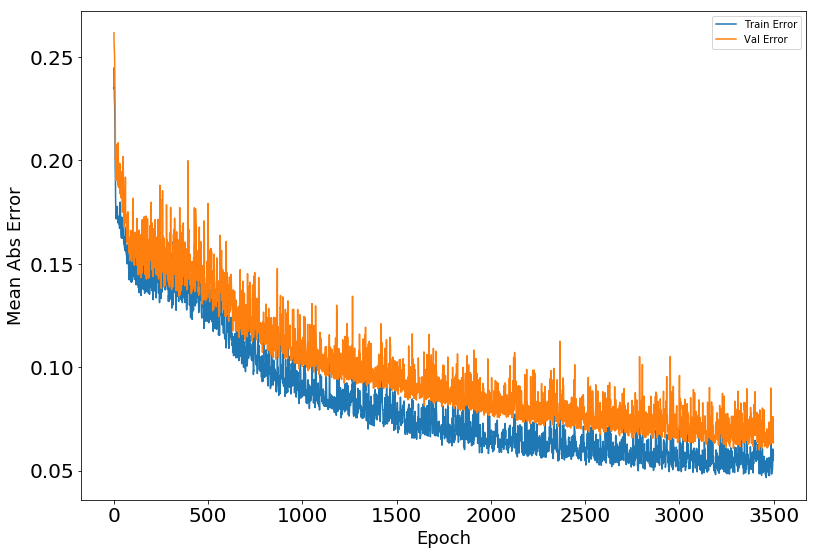

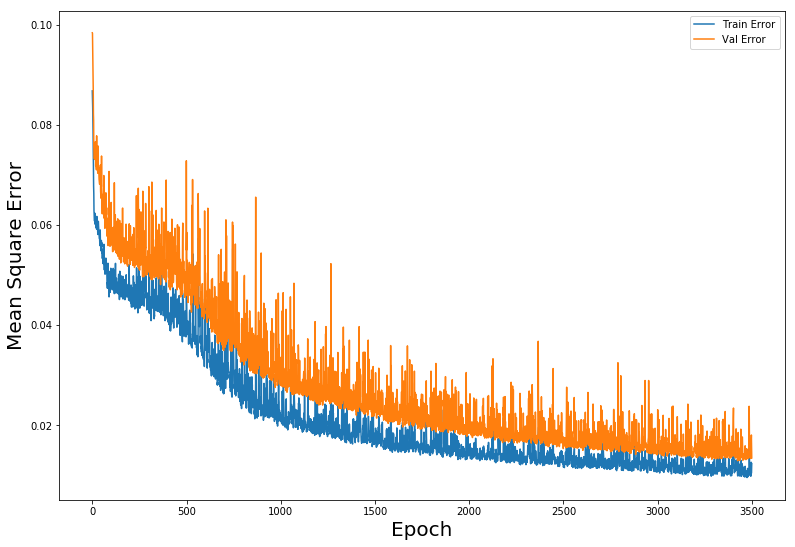

In [16]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize= 18)
  plt.ylabel('Mean Abs Error', fontsize= 18)
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0,1.2])
  plt.tick_params(labelsize=20)
  plt.legend()
  

  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Mean Square Error', fontsize= 20)
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)

**Save model**

In [60]:
#test_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])
test_predictions = best_model.predict(X_test)
print(np.shape(test_predictions))
print(np.shape(Y_test[:,0]))
print(np.shape(Y_test[:,1]))
print(np.shape(Y_test[:,2]))
print(np.shape(Y_test[:,3]))

(59, 4)
(59,)
(59,)
(59,)
(59,)


In [61]:
test_predictions[:,0].shape

(59,)

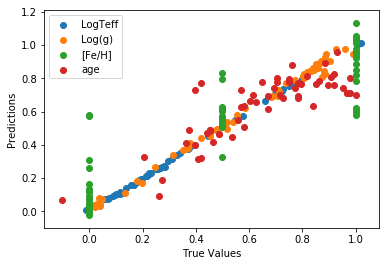

In [62]:
plt.scatter(Y_test[:,0], test_predictions[:,0], label= 'LogTeff')
plt.scatter(Y_test[:,1], test_predictions[:,1], label= 'Log(g)')
plt.scatter(Y_test[:,2], test_predictions[:,2], label= '[Fe/H]')
plt.scatter(Y_test[:,3], test_predictions[:,3], label= 'age')
plt.xlabel('True Values')
plt.ylabel('Predictions')
# plt.axis('equal')
# plt.axis('square')
plt.legend()
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,2])
#_ = plt.plot([1.4, 1.4], [1.4, 1.4])
#print('test predictions=', test_predictions)

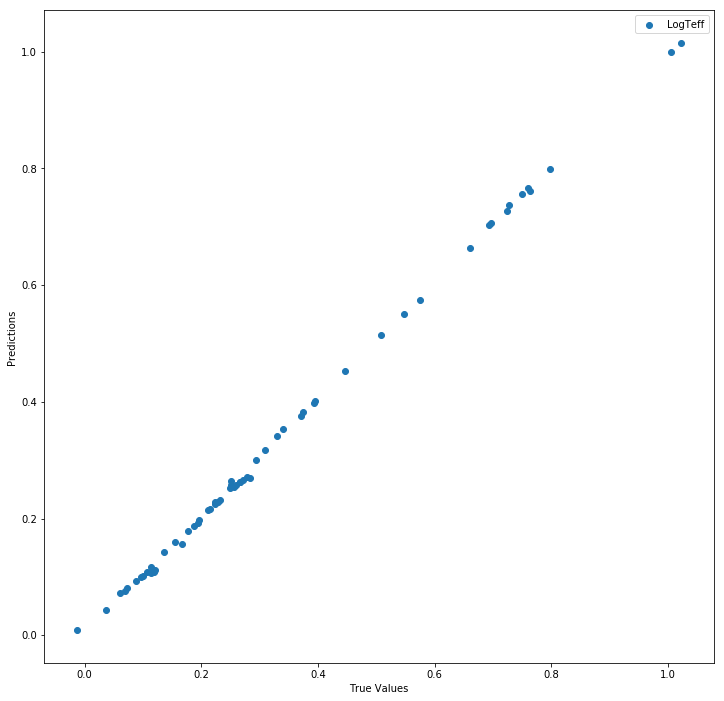

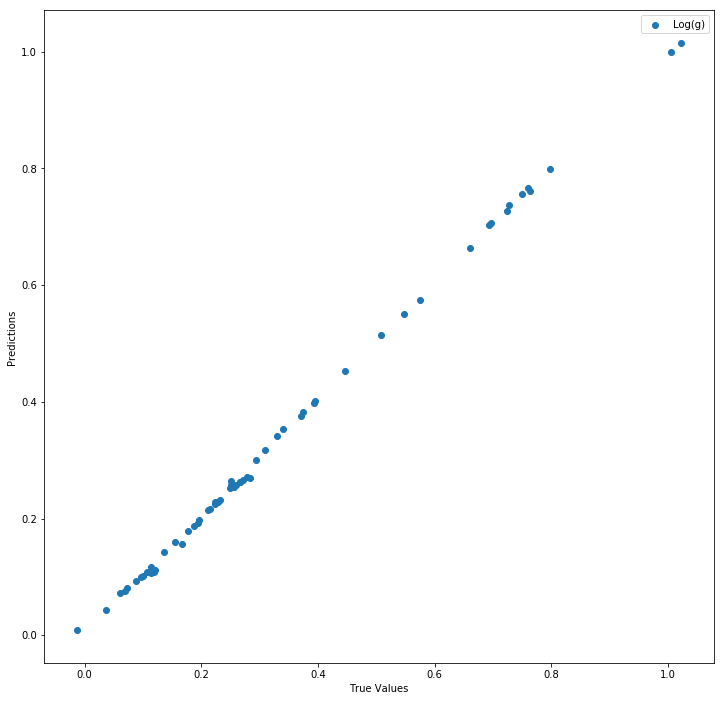

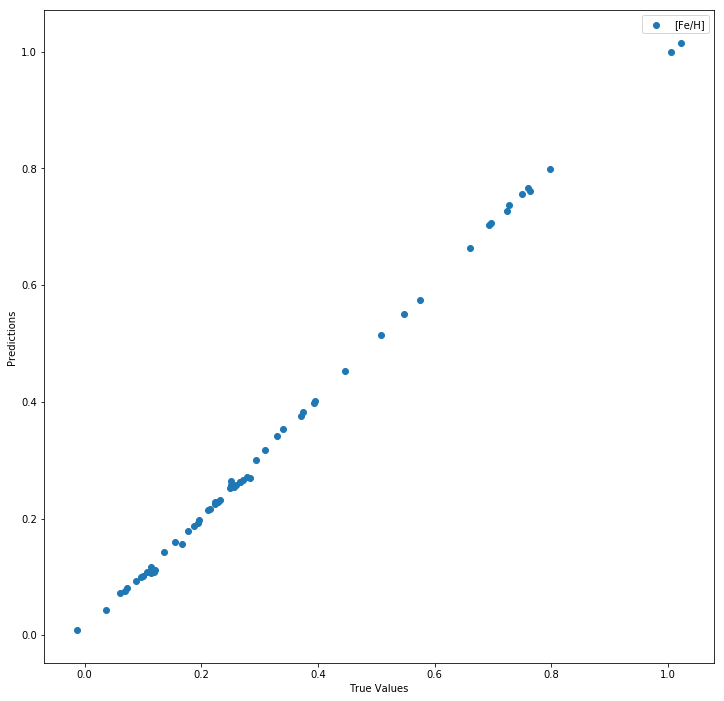

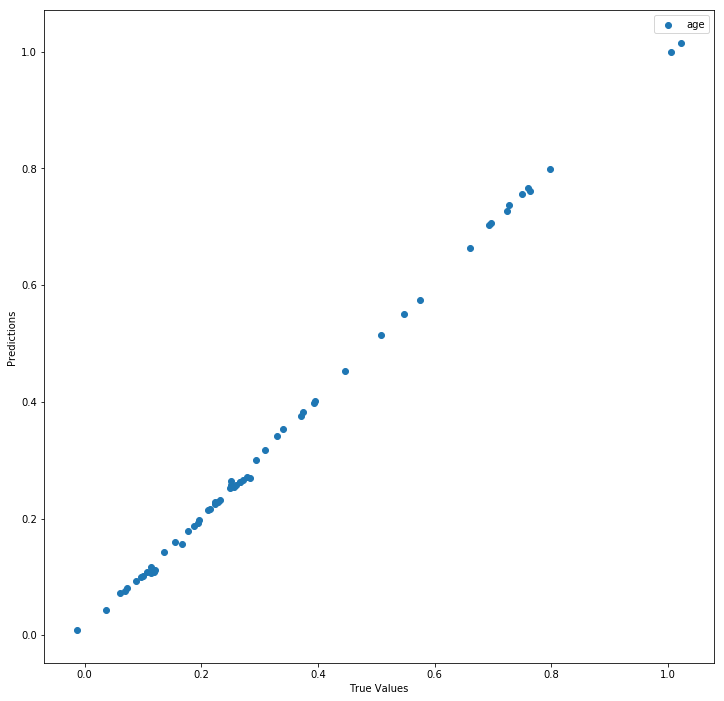

In [63]:
for each_label in ['LogTeff', 'Log(g)', '[Fe/H]', 'age']:
    plt.figure(figsize=(12, 12))
    plt.scatter(Y_test[:,0], test_predictions[:,0], label= each_label)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.pause(0.01)

In [64]:
#Loading the data
#RVSFlux
pathrvs = '/Users/aishasultan/work/synple-gaia/run/CNN/age_parameter/RVS/spectra/normspectra_feh_pos00+pos.25+neg.25.npy'
norm_rvsflux = np.load (pathrvs)
print('shape of norm rvsflux:', np.shape(norm_rvsflux))

#BPFlux
pathbp = '/Users/aishasultan/work/synple-gaia/run/CNN/age_parameter/BP/spectra/spectra_feh_pos00+pos.25+neg.25.h5'
readbp = h5py.File(pathbp, 'r') 
bpflux = readbp.get('bpflux')
bpflux = np.array(bpflux)
print('shape of bpflux:', np.shape(bpflux))


norm_bpflux= []

for ii in range(np.shape(bpflux)[0]):    
    max_flux= np.max(bpflux[ii])
    normflux = bpflux[ii]/ max_flux
    #plt.plot(np.arange(33), normflux)
    #print('normflux:',normflux)
    norm_bpflux.append(normflux)



norm_bpflux= np.array(norm_bpflux)

#print('shape of norm bpflux:', np.shape(norm_bpflux))
#print('shape of norm bpflux:', print(norm_bpflux[0:10]))

#RPFlux
pathrp ='/Users/aishasultan/work/synple-gaia/run/CNN/age_parameter/RP/spectra/spectra_feh_pos00+pos.25+neg.25.h5'
readrp = h5py.File(pathrp, 'r')
print(readrp.keys())
rpflux = readrp.get('rpflux')
rpflux = np.array(rpflux)
print('shape of rpflux:', np.shape(rpflux))


norm_rpflux= []
for ii in range(np.shape(rpflux)[0]):
        max_flux= np.max(rpflux[ii])
        normflux = rpflux[ii]/ max_flux
        #plt.plot(np.arange(40), normflux)
        #print('normflux:',normflux)
        norm_rpflux.append(normflux)


norm_rpflux= np.array(norm_rpflux)

#print('shape of norm_rpflux:', np.shape(norm_rpflux))
#print('output of norm_flux:', print(norm_rpflux[0:10]))

mist0 = '/Users/aishasultan/work/MIST/feh_pos0.00_100randstr_EEP0.h5'
mist1 = '/Users/aishasultan/work/MIST/feh_pos.25_100randstr_EEP0.h5'
mist2 = '/Users/aishasultan/work/MIST/feh_neg.25_100randstr_EEP0.h5'

readmist0 = h5py.File(mist0, 'r')
readmist1 = h5py.File(mist1, 'r')
readmist2 = h5py.File(mist2, 'r')


#reading MIST0 file
print(readmist0.keys())
mist_logteff0 = readmist0.get('logteff_sel')
teff_sel0 = np.array(mist_logteff0)
mist_logg0 = readmist0.get ('logg_sel')
logg_sel0 = np.array(mist_logg0)
mist_feh0 = readmist0.get ('feh_sel')
feh_sel0 = np.array(mist_feh0)
mist_age0 = readmist0.get ('age_sel')
age_sel0 = np.array(mist_age0)


#reading MIST1 file
#print(readmist1.keys())
mist_logteff1 = readmist1.get('logteff_sel')
teff_sel1 = np.array(mist_logteff1)
mist_logg1 = readmist1.get ('logg_sel')
logg_sel1 = np.array(mist_logg1)
mist_feh1 = readmist1.get ('feh_sel')
feh_sel1 = np.array(mist_feh1)
mist_age1 = readmist1.get ('age_sel')
age_sel1 = np.array(mist_age1)

#reading MIST2 file
#print(readmist1.keys())
mist_logteff2 = readmist2.get('logteff_sel')
teff_sel2 = np.array(mist_logteff2)
mist_logg2 = readmist2.get ('logg_sel')
logg_sel2 = np.array(mist_logg2)
mist_feh2 = readmist2.get ('feh_sel')
feh_sel2 = np.array(mist_feh2)
mist_age2 = readmist2.get ('age_sel')
age_sel2 = np.array(mist_age2)


#MIST all parameters
logteff = np.hstack((teff_sel0, teff_sel1, teff_sel2))
logg = np.hstack ((logg_sel0, logg_sel1, logg_sel2))
feh = np.hstack ((feh_sel0, feh_sel1, feh_sel2))
age = np.hstack ((age_sel0, age_sel1, age_sel2))

print(age.max())
print(feh)

#features
num_tot = len(logteff)
print('total number of input stars =', num_tot)
np.random.seed(0)
plim = 0.8
ran_frac = np.random.uniform(0,1,num_tot)
#print('ranfrac=' , ran_frac)

#Input flux data of RVS, BP, RP
x_RVStrain = norm_rvsflux[ran_frac < plim, :]
print('number of RVS training data=', len(x_RVStrain[:,0]))
x_RVScv = norm_rvsflux[ran_frac >= plim, :] #test set we left for the application

x_BPtrain = norm_bpflux[ran_frac < plim, :]
print('number of BP training data=', len(x_BPtrain[:,0]))
x_BPcv = norm_bpflux[ran_frac >= plim, :]

x_RPtrain =norm_rpflux[ran_frac < plim, :]
print('number of RP training data=', len(x_RPtrain[:,0]))
x_RPcv = norm_rpflux[ran_frac >= plim, :]

#print('x_BPtrain', x_BPtrain)

#x_train_combined = np.vstack (x_RVStrain[0,:], x_RPtrain[0,:]) 

#output label which is the logteff, log g, feh, and age
y_logteff_train = logteff[ran_frac< plim]
y_logteff_cv = logteff[ran_frac >= plim] #test set

y_logg_train = logg[ran_frac< plim]
y_logg_cv = logg[ran_frac >= plim] #test set

y_feh_train = feh[ran_frac< plim]
y_feh_cv = feh[ran_frac >= plim] #test set

y_age_train = age[ran_frac< plim]
y_age_cv = age[ran_frac >= plim] #test set

print('The size of CVS for the input flux data')
#print('RVS cvs=', np.shape(x_RVScv))
#print('BP cvs=', np.shape(x_BPcv))
print('RP cvs=', np.shape(x_RPcv))

print('the size of output label=', np.shape(y_logteff_train) )

#id = np.linspace(0, len(x_RVStrain[:, 0])-1, len(x_RVStrain[:, 0]))
#plt.plot(id, y_logteff_train)
#plt.show()

#mean_labels=np.mean(logteff)
#std_labels=np.std(logteff)
#print('mean and std teff=', mean_labels, std_labels)
# def normalize(labels):
#     # Normalize labels
#     mean_labels=np.mean(labels)
#     std_labels=np.std(labels)
#     return (labels-mean_labels) / std_labels, mean_labels, std_labels


# def normalize_test(labels, mean, std):
#     return (labels - mean) / std

def normalize(labels):
    # Normalize labels
    min_labels=np.min(labels)
    max_labels=np.max(labels)
    return (labels-min_labels) / (max_labels - min_labels), min_labels, max_labels


def normalize_test(labels, min_value, max_value):
    return (labels - min_value) / (max_value - min_value)

#normalize the y labels, the log teff and log g 

#output label which is the logteff and log g
# y_logteff_train, mean_ylt_train, std_ylt_train = normalize(y_logteff_train)
# y_logteff_cv = normalize_test(y_logteff_cv, mean_ylt_train, std_ylt_train)

# y_logg_train, mean_yl_train, std_lt_train = normalize(y_logg_train)
# y_logg_cv = normalize_test(y_logg_cv, mean_yl_train, std_lt_train)

# y_feh_train, mean_yf_train, std_yf_train = normalize(y_feh_train)
# y_feh_cv = normalize_test(y_feh_cv, mean_yf_train, std_yf_train) #test set

# y_age_train, mean_ya_train, std_ya_train = normalize(y_age_train)
# y_age_cv = normalize_test(y_age_cv, mean_ya_train, std_ya_train) #test set



y_logteff_train, min_ylt_train, max_ylt_train = normalize(y_logteff_train)
y_logteff_cv = normalize_test(y_logteff_cv, min_ylt_train, max_ylt_train)

y_logg_train, min_yl_train, max_lt_train = normalize(y_logg_train)
y_logg_cv = normalize_test(y_logg_cv, min_yl_train, max_lt_train)

y_feh_train, min_yf_train, max_yf_train = normalize(y_feh_train)
y_feh_cv = normalize_test(y_feh_cv, min_yf_train, max_yf_train) #test set

y_age_train, min_ya_train, max_ya_train = normalize(y_age_train)
y_age_cv = normalize_test(y_age_cv, min_ya_train, max_ya_train) #test set

shape of norm rvsflux: (300, 1134)
shape of bpflux: (300, 33)
<KeysViewHDF5 ['rpflux']>
shape of rpflux: (300, 40)
<KeysViewHDF5 ['age_sel', 'feh_sel', 'logg_sel', 'logteff_sel']>
10.3
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25  0.

In [65]:
y_logteff_cv.min(), y_logteff_cv.max()

(-0.012904096193126336, 1.0218519268253974)

In [66]:
y_logg_cv.min(), y_logg_cv.max()

(0.017878338622628866, 0.990608413942865)

In [67]:
y_feh_cv.min(), y_feh_cv.max()

(0.0, 1.0)

In [68]:
y_age_cv.min(), y_age_cv.max()

(-0.1022727272727273, 1.0)

In [69]:
def denormalize(labels, min_label, max_label):
    return labels * (max_label - min_label) + min_label

shape of test_predictions: (241, 4)
print 10 elements of test_predictions: [[0.1006073  0.9887658  0.50835276 0.75019145]
 [0.17199172 0.270745   0.54163444 0.47981226]
 [0.3656317  0.37116662 0.7400674  0.35914615]
 [0.03983956 0.9597916  0.8242204  0.7950659 ]
 [0.19402505 0.34596267 0.5421489  0.5784808 ]
 [0.3567197  0.85753924 0.58446515 0.78483665]
 [0.9219764  0.7740251  0.50944066 0.27236438]
 [0.16118567 0.8977769  0.30416384 0.83038926]
 [0.758708   0.8367737  0.6244014  0.3174683 ]
 [0.15771689 0.2734671  0.48855925 0.85869706]]


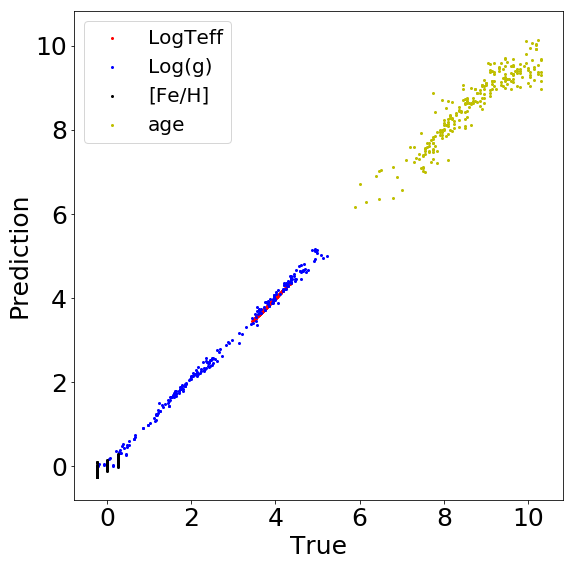

In [70]:
#Unnormalizing the labels (teff)

plt.figure(figsize=(13,9))
train_predictions = best_model.predict(X_train)
#test_predictions = model.predict([x_RPtrain])
print('shape of test_predictions:',np.shape(train_predictions))
print('print 10 elements of test_predictions:', train_predictions[0:10])
plt.scatter(denormalize(Y_train[:,0], min_ylt_train, max_ylt_train), denormalize(train_predictions[:,0], min_ylt_train, max_ylt_train), s= 4.0, c= 'r', label='LogTeff' )
plt.scatter(denormalize(Y_train[:,1], min_yl_train, max_lt_train), denormalize(train_predictions[:,1], min_yl_train, max_lt_train), s= 4.0, c= 'b', label='Log(g)' )
plt.scatter(denormalize(Y_train[:,2], min_yf_train, max_yf_train), denormalize(train_predictions[:,2], min_yf_train, max_yf_train), s= 4.0, c= 'k', label='[Fe/H]' )
plt.scatter(denormalize(Y_train[:,3], min_ya_train, max_ya_train), denormalize(train_predictions[:,3], min_ya_train, max_ya_train), s= 4.0, c= 'y', label='age' )
plt.xlabel(r"True", fontsize=25)
plt.ylabel(r"Prediction", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-2, 3], [-2, 3], color='green')
plt.legend(fontsize=20)


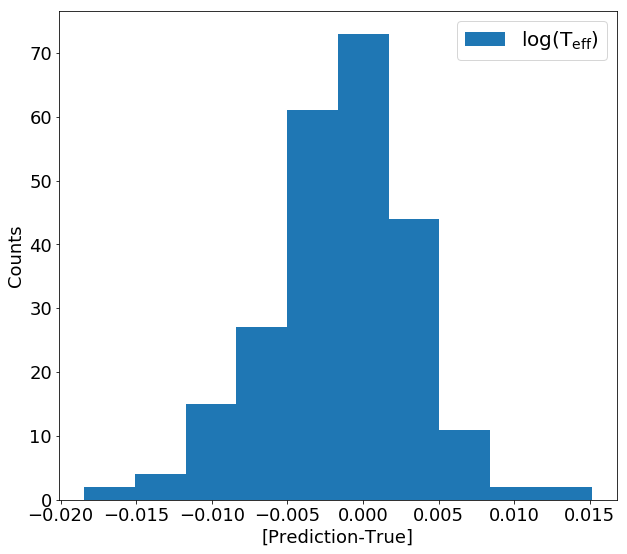

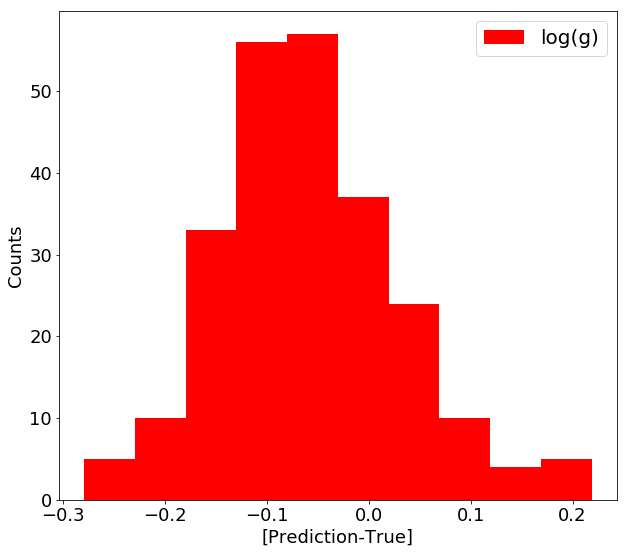

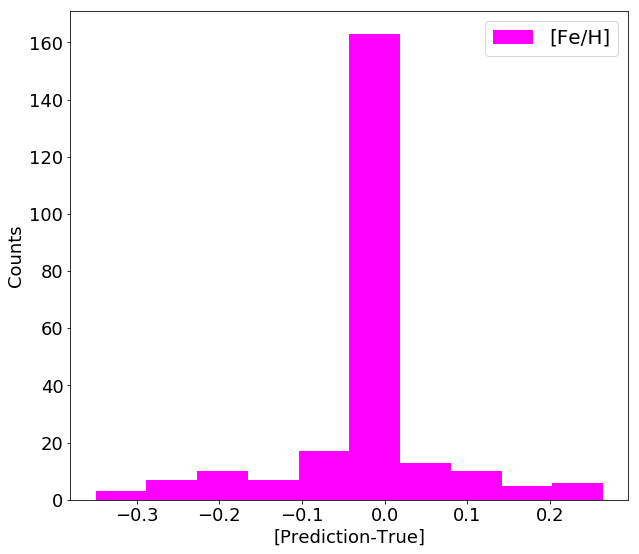

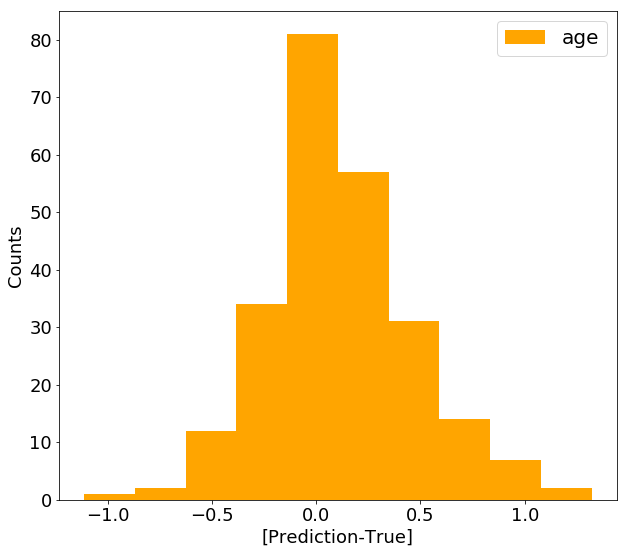

In [71]:
#Making the histogram of denormalized training set 

plt.figure(figsize=(10,9))
data_teff=np.subtract(denormalize(Y_train[:,0], min_ylt_train, max_ylt_train), denormalize(train_predictions[:,0], min_ylt_train, max_ylt_train)) 
data_logg=np.subtract(denormalize(Y_train[:,1], min_yl_train, max_lt_train), denormalize(train_predictions[:,1], min_yl_train, max_lt_train)) 
data_feh=np.subtract(denormalize(Y_train[:,2], min_yf_train, max_yf_train), denormalize(train_predictions[:,2], min_yf_train, max_yf_train)) 
data_age=np.subtract(denormalize(Y_train[:,3], min_ya_train, max_ya_train), denormalize(train_predictions[:,3], min_ya_train, max_ya_train)) 

counts_teff, bins_teff = np.histogram(data_teff)
counts_logg, bins_logg = np.histogram(data_logg)
counts_feh, bins_feh = np.histogram(data_feh)
counts_age, bins_age = np.histogram(data_age)


#histogram for LogTeff
plt.hist(bins_teff[:-1], bins_teff, weights=counts_teff, label= r'$\rm log(\rm T_{\rm eff})$')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for Log(g)
plt.figure(figsize=(10,9))
plt.hist(bins_logg[:-1], bins_logg, weights=counts_logg, label= 'log(g)', color='red')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for [Fe/H]
plt.figure(figsize=(10,9))
plt.hist(bins_feh[:-1], bins_feh, weights=counts_feh, label= '[Fe/H]', color='magenta')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for age
plt.figure(figsize=(10,9))
plt.hist(bins_age[:-1], bins_age, weights=counts_age, label= 'age', color='orange')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()




#print('standard deviation', len(z))
#print(len(z[teff<5000]))
#print(len(z))


# Training Data Set

In [72]:
# getting deviation in Teff bins
nbin = 6
teffbin_edges=np.array([3.4, 3.6, 3.8, 4, 4.2, 4.4])

# pred vs. true
# unnormalised values
teff_pred = denormalize(train_predictions[:,0], min_ylt_train, max_ylt_train)
teff_true = denormalize(Y_train[:,0], min_ylt_train, max_ylt_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('=================================================================================================')
# getting deviation in Teff bins
nbin = 6
loggbin_edges=np.array([ 0., 1.0, 2.0, 3.0, 4.0, 5.0])

# pred vs. true
# unnormalised values
logg_pred = denormalize(train_predictions[:,1], min_yl_train, max_lt_train)
logg_true = denormalize(Y_train[:,1], min_yl_train, max_lt_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))




####################################################################################################################
print('=================================================================================================')
# getting deviation in feh bins
nbin = 6
fehbin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
feh_pred = denormalize(train_predictions[:,2], min_yf_train, max_yf_train)
feh_true = denormalize(Y_train[:,2], min_yf_train, max_yf_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
feh_diff = feh_pred-feh_true

# compute mean and std in Teff bins
feh_diff_mean = np.zeros(nbin) 
feh_diff_std = np.zeros(nbin)
fehbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(feh_true<fehbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(feh_true>fehbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((feh_true>fehbin_edges[i-1]) & (feh_true<fehbin_edges[i]))

    fehbin_mean[i] = np.mean(feh_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    feh_diff_mean[i] = np.mean(feh_diff[indx]) #calculating the mean values of teff_diff from its index 
    feh_diff_std[i] = np.std(feh_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin feh_true=', fehbin_mean)
print('mean of feh_diff=', feh_diff_mean)
print('std of feh_diff=', feh_diff_std)
print('length of feh_diff=', len(feh_diff))

####################################################################################################################
print('=================================================================================================')
# getting deviation in age bins
nbin = 6
agebin_edges=np.array([5, 6, 7, 8, 9, 10])

# pred vs. true
# unnormalised values
age_pred = denormalize(train_predictions[:,3], min_ya_train, max_ya_train)
age_true = denormalize(Y_train[:,3], min_ya_train, max_ya_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
age_diff = feh_pred-feh_true

# compute mean and std in Teff bins
age_diff_mean = np.zeros(nbin) 
age_diff_std = np.zeros(nbin)
agebin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(age_true<agebin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(age_true>agebin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((age_true>agebin_edges[i-1]) & (age_true<agebin_edges[i]))

    agebin_mean[i] = np.mean(age_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    age_diff_mean[i] = np.mean(age_diff[indx]) #calculating the mean values of teff_diff from its index 
    age_diff_std[i] = np.std(age_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin age_true=', agebin_mean)
print('mean of age_diff=', age_diff_mean)
print('std of age_diff=', age_diff_std)
print('length of age_diff=', len(age_diff))

mean of bin teff_true= [       nan 3.54028801 3.66852655 3.89894971 4.09419369 4.27553804]
mean of teff_diff= [       nan 0.00153462 0.000636   0.00284593 0.00300129 0.00185469]
std of teff_diff= [       nan 0.00590676 0.00447691 0.00433067 0.00351252 0.00556675]
length of teff_diff= 241
mean of bin logg_true= [-0.14076367  0.46853351  1.56322392  2.37863387  3.68852145  4.51308024]
mean of logg_diff= [0.18601031 0.02586541 0.08513115 0.05840793 0.0344849  0.05547709]
std of logg_diff= [0.0671798  0.08688105 0.06058324 0.08008832 0.08579232 0.10253362]
length of logg_diff= 241
mean of bin feh_true= [  nan   nan -0.25  0.25   nan   nan]
mean of feh_diff= [        nan         nan  0.07821776 -0.03794545         nan         nan]
std of feh_diff= [       nan        nan 0.09838312 0.07654341        nan        nan]
length of feh_diff= 241
mean of bin age_true= [       nan 5.9        6.55625    7.651      8.50592105 9.66979167]
mean of age_diff= [       nan 0.13708603 0.08434711 0.02027556 0.

/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/aishasultan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


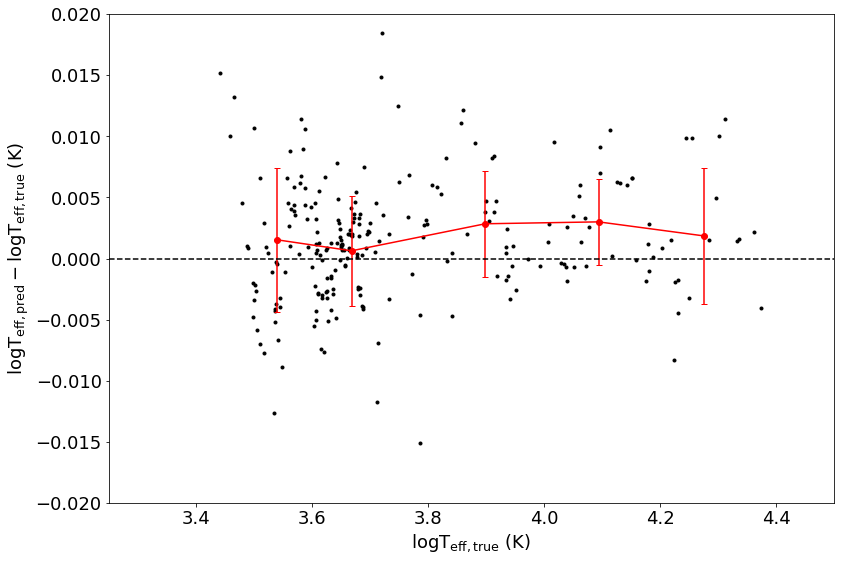

In [73]:
# plot of logteff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([3.25,4.5])
ylim=np.array([-0.020, 0.020])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm logT_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$\rm logT_{\rm eff,pred}-\rm logT_{\rm eff,true}$ (K)", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

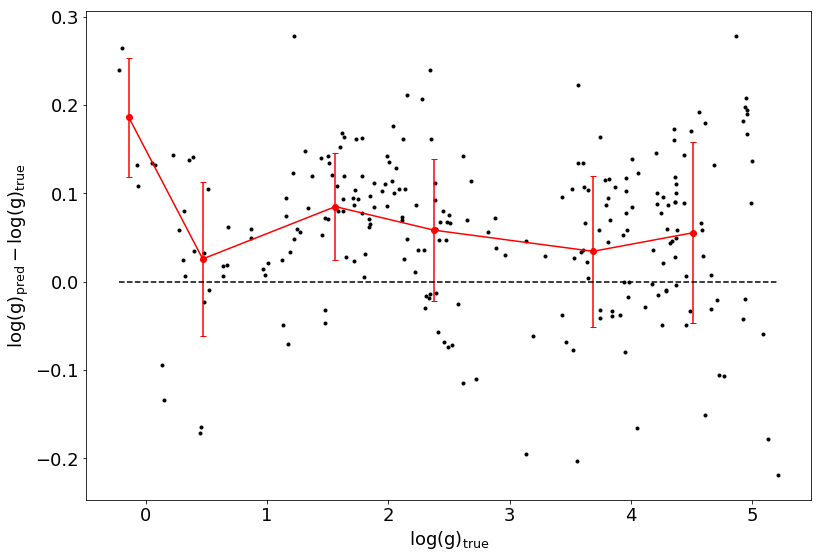

In [74]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
# xlim=np.array([-2.5,2.5])
# ylim=np.array([-1.5,1.5])
# plt.xlim(xlim[0],xlim[1]) #plotting the xlim
# plt.ylim(ylim[0],ylim[1])


# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)



# draw y=0 line
xline = np.linspace(logg_true.min(),logg_true.max(), 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')




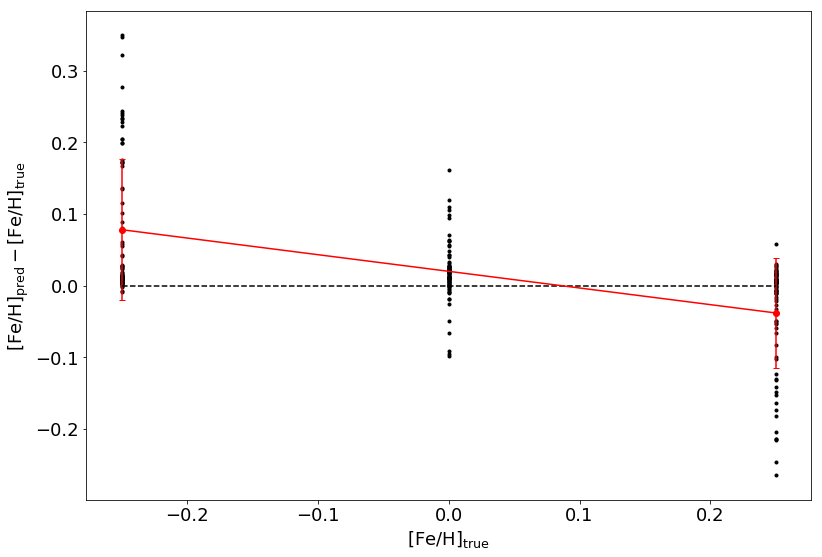

In [75]:
# plot of feh
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(feh_true, feh_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(fehbin_mean, feh_diff_mean, yerr=feh_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 



# set x, y lim plot range
# xlim=np.array([-2.2, 2.1])
# ylim=np.array([-1.5, 1.5])
# plt.xlim(xlim[0],xlim[1]) #plotting the xlim
# plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm [Fe/H]_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm [Fe/H]_{\rm pred}-\rm [Fe/H]_{\rm true}$ ", fontsize=18)

# draw y=0 line
# xline = np.linspace(xlim[0],xlim[1], 2)
# yline = np.zeros_like(xline)
# plt.plot(xline,yline,linestyle='--',c='k')


xline = np.linspace(feh_true.min(),feh_true.max(), 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

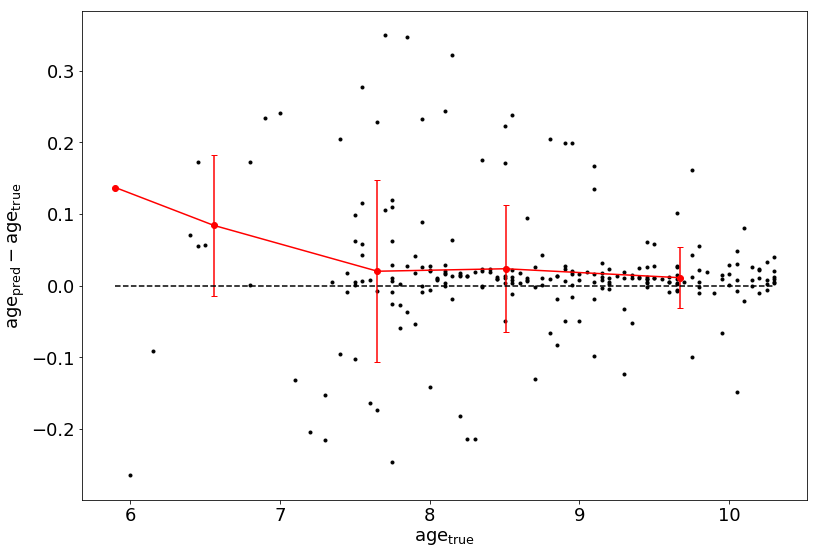

In [76]:
# plot of age
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(age_true, age_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(agebin_mean, age_diff_mean, yerr=age_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 



# set x, y lim plot range
# xlim=np.array([-2.5, 2.1])
# ylim=np.array([-1.5,1.5])
# plt.xlim(xlim[0],xlim[1]) #plotting the xlim
# plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm age_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm age_{\rm pred}-\rm age_{\rm true}$ ", fontsize=18)

# draw y=0 line
# xline = np.linspace(xlim[0],xlim[1], 2)
# yline = np.zeros_like(xline)
# plt.plot(xline,yline,linestyle='--',c='k')

xline = np.linspace(age_true.min(),age_true.max(), 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

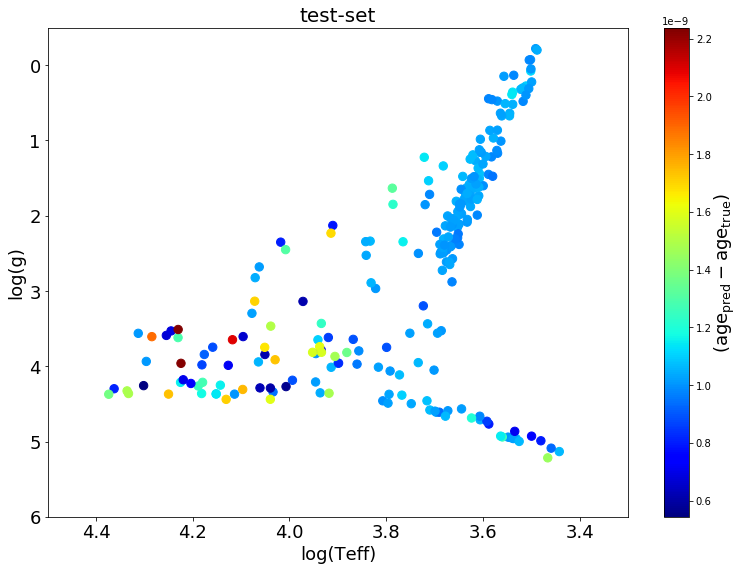

In [87]:
#Plot true log(g) vs. trueTeff (i.e. HR diagram) and 
#colour coded with the |age_pred-age_true|. 


plt.figure(figsize=(13,9))
marker_size = 70
plt.scatter(teff_true, logg_true, s= marker_size, c= np.power(10,age_diff-9.0), cmap ='jet' )
plt.tick_params(labelsize=18)
plt.xlabel('log(Teff)', fontsize=18)
plt.ylabel('log(g)', fontsize=18)
plt.title('training set', fontsize = 20)
plt.axis([4.5, 3.3, 6, -0.5])
cbar= plt.colorbar()
cbar.set_label(r"($\rm age_{\rm pred}-\rm age_{\rm true})$" , labelpad=+1, fontsize=18)
plt.show()



# Cross Validation Set

(59, 4)
(59,)
(59,)
(59,)
(59,)
len of y_cv_stack= 59


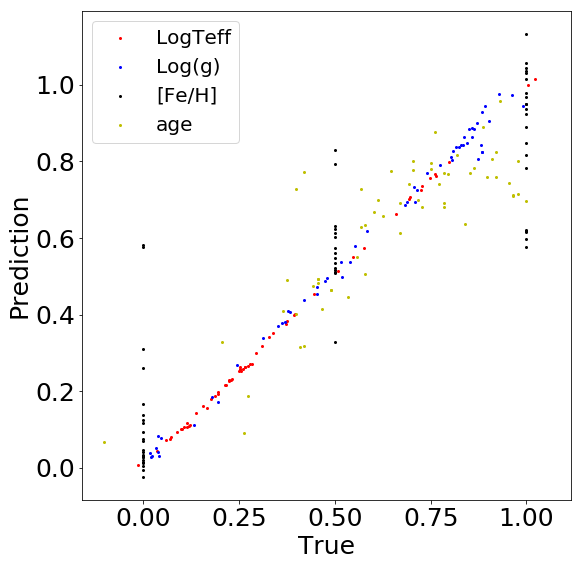

In [78]:
#Test set (x_cv)

plt.figure(figsize=(13,9))
cv_predictions = best_model.predict(X_test)
#cv_predictions = model.predict([x_RPcv])
print(np.shape(Y_test))

print(np.shape(Y_test[:,0]))
print(np.shape(Y_test[:,1]))
print(np.shape(Y_test[:,2]))
print(np.shape(Y_test[:,3]))


plt.scatter(Y_test[:,0], cv_predictions[:,0], s= 4.0, c= 'r', label='LogTeff')
plt.scatter(Y_test[:,1], cv_predictions[:,1], s= 4.0, c= 'b', label='Log(g)')
plt.scatter(Y_test[:,2], cv_predictions[:,2], s= 4.0, c= 'k', label='[Fe/H]' )
plt.scatter(Y_test[:,3], cv_predictions[:,3], s= 4.0, c= 'y', label='age' )

plt.xlabel(r"True", fontsize=25)
plt.ylabel(r"Prediction", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-2, 3], [-2, 3], color='green')
plt.legend(fontsize=20)


print('len of y_cv_stack=', len(Y_test))



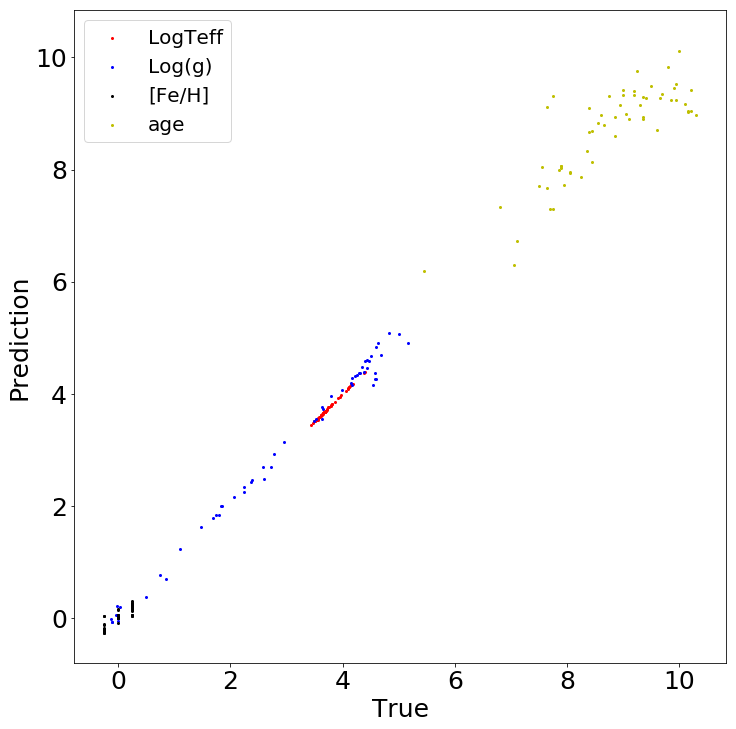

In [88]:
#Unnormalizing the labels (teff)

#test_predictions = model.predict([x_RPtrain])
plt.figure(figsize=(12, 12))
plt.scatter(denormalize(Y_test[:,0], min_ylt_train, max_ylt_train), denormalize(cv_predictions[:,0], min_ylt_train, max_ylt_train), s= 4.0, c= 'r', label='LogTeff' )
plt.scatter(denormalize(Y_test[:,1], min_yl_train, max_lt_train), denormalize(cv_predictions[:,1], min_yl_train, max_lt_train), s= 4.0, c= 'b', label='Log(g)' )
plt.scatter(denormalize(Y_test[:,2], min_yf_train, max_yf_train), denormalize(cv_predictions[:,2], min_yf_train, max_yf_train), s= 4.0, c= 'k', label='[Fe/H]' )
plt.scatter(denormalize(Y_test[:,3], min_ya_train, max_ya_train), denormalize(cv_predictions[:,3], min_ya_train, max_ya_train), s= 4.0, c= 'y', label='age' )
plt.xlabel(r"True", fontsize=25)
plt.ylabel(r"Prediction", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-2, 3], [-2, 3], color='green')
plt.legend(fontsize=20)


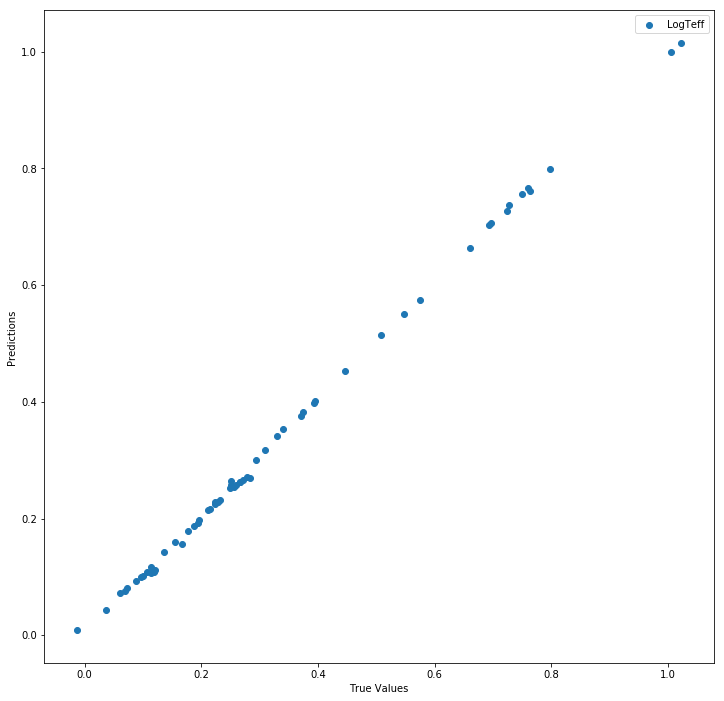

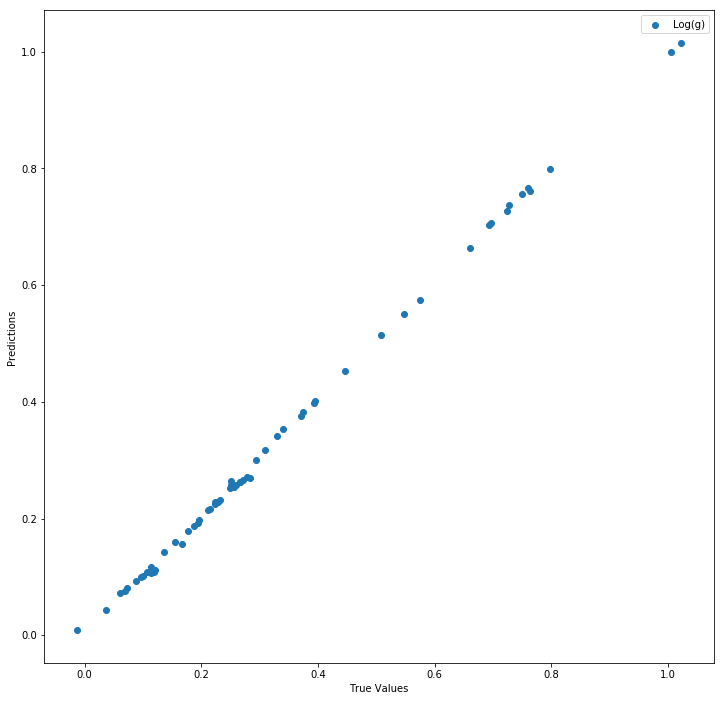

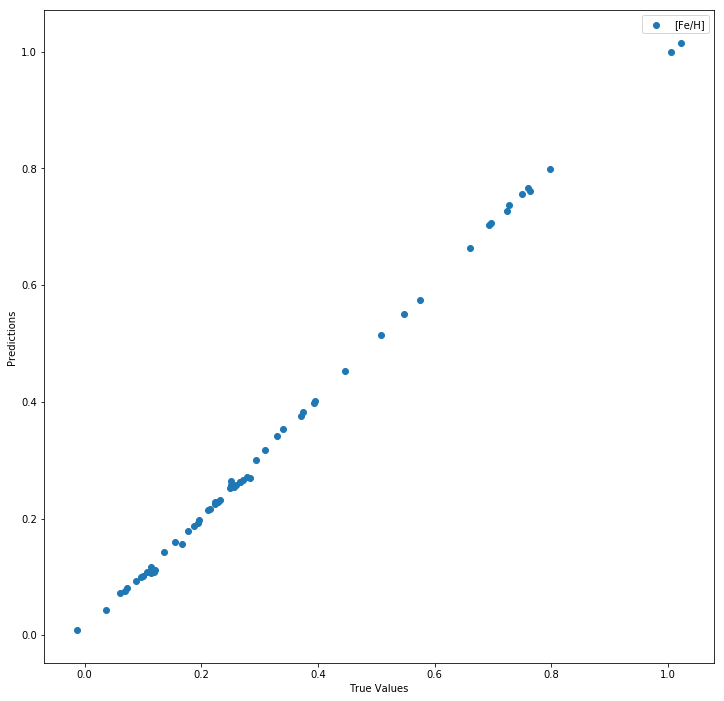

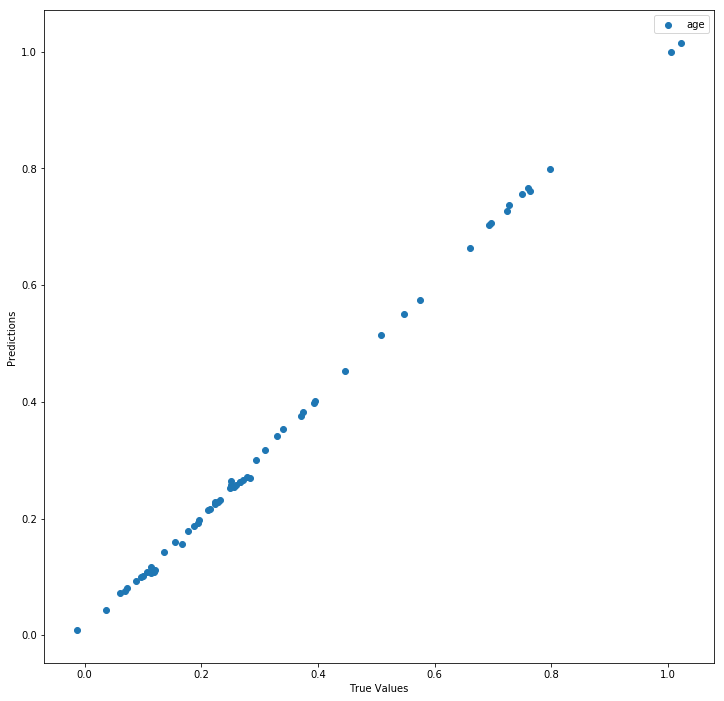

In [89]:
for each_label in ['LogTeff', 'Log(g)', '[Fe/H]', 'age']:
    plt.figure(figsize=(12, 12))
    plt.scatter(Y_test[:,0], cv_predictions[:,0], label= each_label)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.pause(0.01)

In [95]:
# getting deviation in Teff bins
nbin = 6
teffbin_edges=np.array([3.4, 3.6, 3.8, 4, 4.2, 4.4])

# pred vs. true
# unnormalised values
teff_pred = denormalize(cv_predictions[:,0], min_ylt_train, max_ylt_train)
teff_true = denormalize(Y_test[:,0], min_ylt_train, max_ylt_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('=================================================================================================')
# getting deviation in Teff bins
nbin = 6
loggbin_edges=np.array([ 0., 1.0, 2.0, 3.0, 4.0, 5.0])

# pred vs. true
# unnormalised values
logg_pred = denormalize(cv_predictions[:,1], min_yl_train, max_lt_train)
logg_true = denormalize(Y_test[:,1], min_yl_train, max_lt_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))




####################################################################################################################
print('=================================================================================================')
# getting deviation in feh bins
nbin = 6
fehbin_edges=np.array([-1.5, -0.5, 0., 0.5, 1.0, 1.5, 2.0])

# pred vs. true
# unnormalised values
feh_pred = denormalize(cv_predictions[:,2], min_yf_train, max_yf_train)
feh_true = denormalize(Y_test[:,2], min_yf_train, max_yf_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
feh_diff = feh_pred-feh_true

# compute mean and std in Teff bins
feh_diff_mean = np.zeros(nbin) 
feh_diff_std = np.zeros(nbin)
fehbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(feh_true<fehbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(feh_true>fehbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((feh_true>fehbin_edges[i-1]) & (feh_true<fehbin_edges[i]))

    fehbin_mean[i] = np.mean(feh_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    feh_diff_mean[i] = np.mean(feh_diff[indx]) #calculating the mean values of teff_diff from its index 
    feh_diff_std[i] = np.std(feh_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin feh_true=', fehbin_mean)
print('mean of feh_diff=', feh_diff_mean)
print('std of feh_diff=', feh_diff_std)
print('length of feh_diff=', len(feh_diff))

####################################################################################################################
print('=================================================================================================')
# getting deviation in age bins
nbin = 6
agebin_edges=np.array([5, 6, 7, 8, 9, 10])

# pred vs. true
# unnormalised values
age_pred = denormalize(cv_predictions[:,3], min_ya_train, max_ya_train)
age_true = denormalize(Y_test[:,3], min_ya_train, max_ya_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
age_diff = feh_pred-feh_true

# compute mean and std in Teff bins
age_diff_mean = np.zeros(nbin) 
age_diff_std = np.zeros(nbin)
agebin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(age_true<agebin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(age_true>agebin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((age_true>agebin_edges[i-1]) & (age_true<agebin_edges[i]))

    agebin_mean[i] = np.mean(age_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    age_diff_mean[i] = np.mean(age_diff[indx]) #calculating the mean values of teff_diff from its index 
    age_diff_std[i] = np.std(age_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin age_true=', agebin_mean)
print('mean of age_diff=', age_diff_mean)
print('std of age_diff=', age_diff_std)
print('length of age_diff=', len(age_diff))



mean of bin teff_true= [       nan 3.53202412 3.68359671 3.88728018 4.12285668 4.38638492]
mean of teff_diff= [        nan  0.00232659  0.00172583  0.00409608  0.00435245 -0.00596877]
std of teff_diff= [       nan 0.00806138 0.00575661 0.0025289  0.00380389 0.00042632]
length of teff_diff= 59
mean of bin logg_true= [-0.05890698  0.53242177  1.64476704  2.49320355  3.67586596  4.48900856]
mean of logg_diff= [ 0.07434701 -0.01373318  0.11883711  0.07004051  0.05873012  0.02777887]
std of logg_diff= [0.0854603  0.1227497  0.03370213 0.08416077 0.07829691 0.18419045]
length of logg_diff= 59
mean of bin feh_true= [  nan   nan -0.25  0.25   nan   nan]
mean of feh_diff= [        nan         nan  0.05969996 -0.06203771         nan         nan]
std of feh_diff= [       nan        nan 0.08139541 0.08533864        nan        nan]
length of feh_diff= 59
mean of bin age_true= [       nan 5.45       6.8        7.65714286 8.50666667 9.675     ]
mean of age_diff= [        nan -0.08643699  0.01104975  

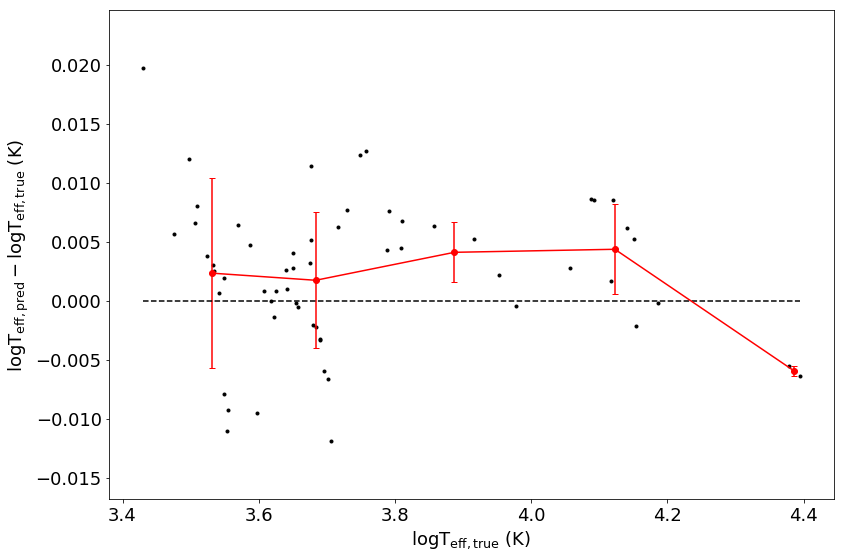

In [96]:

# plot of logteff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
#xlim=np.array([-1.5,2.4])
#ylim=np.array([-0.25,0.25])
#plt.xlim(xlim[0],xlim[1]) #plotting the xlim
#plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm logT_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$\rm logT_{\rm eff,pred}-\rm logT_{\rm eff,true}$ (K)", fontsize=18)

# draw y=0 line
# xline = np.linspace(xlim[0],xlim[1], 2)
xline = np.linspace(teff_true.min(), teff_true.max(), 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')





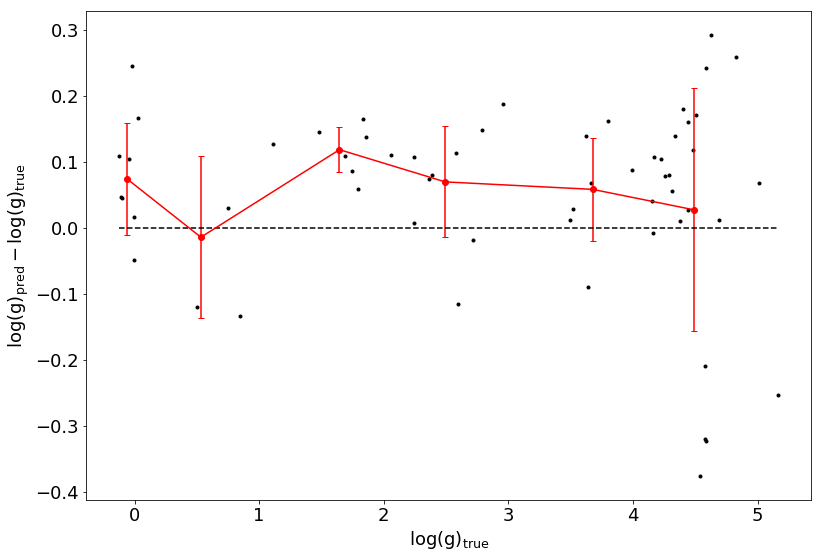

In [97]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
# xlim=np.array([-2.5,2.5])
# ylim=np.array([-1.5,1.5])
# plt.xlim(xlim[0],xlim[1]) #plotting the xlim
# plt.ylim(ylim[0],ylim[1])


# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)



# draw y=0 line
# xline = np.linspace(xlim[0],xlim[1], 2)
# yline = np.zeros_like(xline)
# plt.plot(xline,yline,linestyle='--',c='k')

xline = np.linspace(logg_true.min(), logg_true.max(), 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')



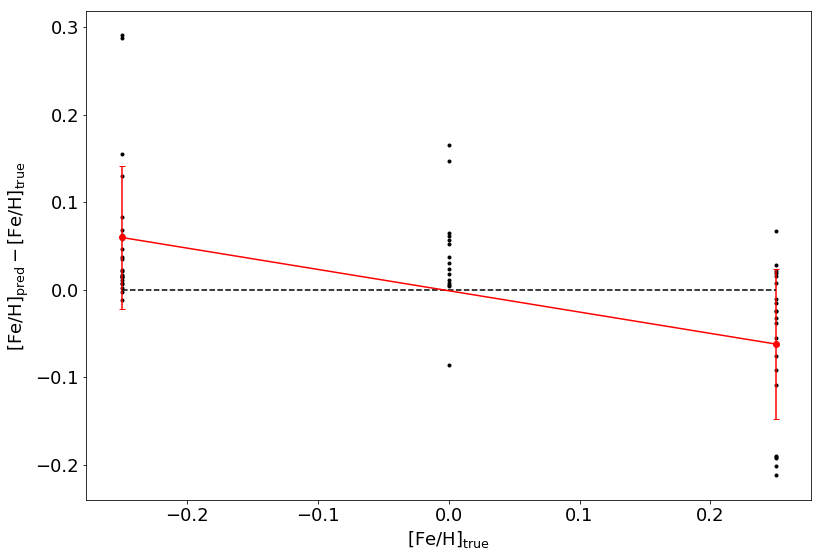

In [98]:
# plot of feh
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(feh_true, feh_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(fehbin_mean, feh_diff_mean, yerr=feh_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 



# set x, y lim plot range
# xlim=np.array([-2.2, 2.1])
# ylim=np.array([-1.8, 1.8])
# plt.xlim(xlim[0],xlim[1]) #plotting the xlim
# plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm [Fe/H]_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm [Fe/H]_{\rm pred}-\rm [Fe/H]_{\rm true}$ ", fontsize=18)

# draw y=0 line
# xline = np.linspace(xlim[0],xlim[1], 2)
# yline = np.zeros_like(xline)
# plt.plot(xline,yline,linestyle='--',c='k')


xline = np.linspace(feh_true.min(), feh_true.max(), 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

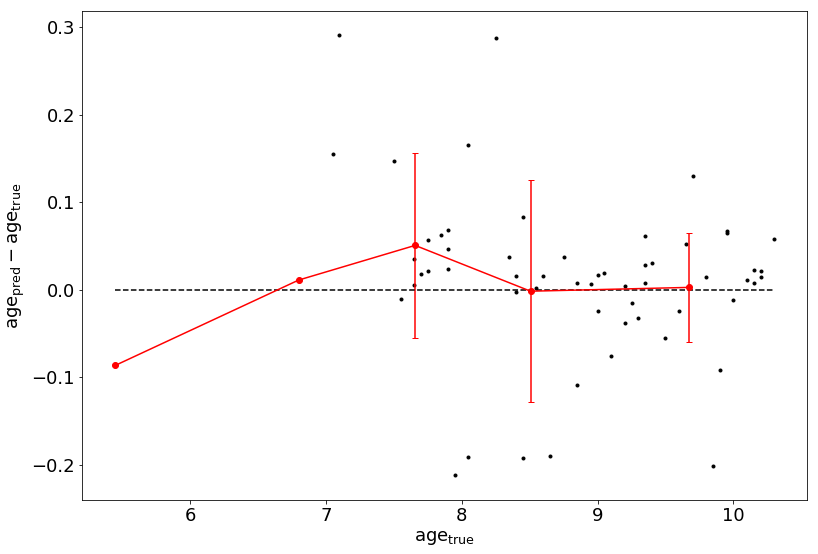

In [99]:
# plot of age
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(age_true, age_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(agebin_mean, age_diff_mean, yerr=age_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 



# set x, y lim plot range
# xlim=np.array([-3.0, 2.1])
# ylim=np.array([-2.0, 2.0])
# plt.xlim(xlim[0],xlim[1]) #plotting the xlim
# plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm age_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm age_{\rm pred}-\rm age_{\rm true}$ ", fontsize=18)

# draw y=0 line
# xline = np.linspace(xlim[0],xlim[1], 2)
# yline = np.zeros_like(xline)
# plt.plot(xline,yline,linestyle='--',c='k')

xline = np.linspace(age_true.min(), age_true.max(), 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

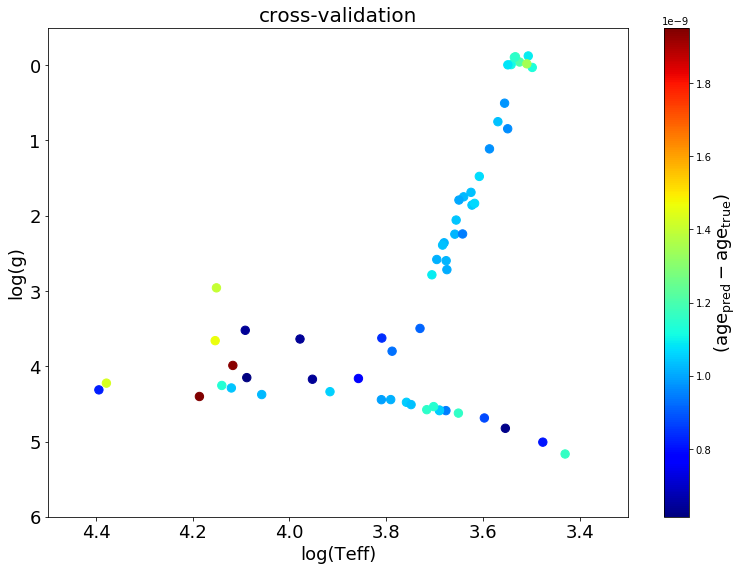

In [100]:
#Plot true log(g) vs. trueTeff (i.e. HR diagram) and 
#colour coded with the |age_pred-age_true|. 


plt.figure(figsize=(13,9))
marker_size = 70
plt.scatter(teff_true, logg_true, s= marker_size, c= np.power(10,age_diff-9.0), cmap ='jet' )
plt.tick_params(labelsize=18)
plt.xlabel('log(Teff)', fontsize=18)
plt.ylabel('log(g)', fontsize=18)
plt.title('cross-validation', fontsize = 20)
plt.axis([4.5, 3.3, 6, -0.5])
cbar= plt.colorbar()
cbar.set_label(r"($\rm age_{\rm pred}-\rm age_{\rm true})$" , labelpad=+1, fontsize=18)
plt.show()

